<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/230701_DD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Concept drift tolerant machine learning method

In [2]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [4]:
import random
import os
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

# 실험을 위한 기본적인 function 들...

In [5]:
import sys, os
import math

from torch.autograd import Variable
from argparse import Namespace
#from FRTrain_arch import Generator, DiscriminatorF, DiscriminatorR, weights_init_normal, test_model
#from FRTrain_arch import weights_init_normal, test_model
import warnings
warnings.filterwarnings("ignore")

plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'

In [6]:
main_figsize=(15,3)

In [7]:
#  I(Z,B) > 0의 관계에 대해 z0를 전처리
class Sensitivity_Adapter(nn.Module):

    def __init__(self,input_dim):
        """Initializes DiscriminatorF with torch components."""

        super(Sensitivity_Adapter, self).__init__()

        self.input_dim = input_dim
        self.fc1 = nn.ModuleList()
        #self.fc2 = nn.ModuleList()
        self.fc3 = nn.ModuleList()

        for i in range(self.input_dim):
            self.fc1.append(nn.Linear(2, self.input_dim*10))
            #self.fc2.append(nn.BatchNorm1d(num_features=50))
            self.fc3.append(nn.Linear(self.input_dim*10, 1))

        #self.fc = nn.Linear(input_dim, input_dim)

    def forward(self,x,b):
        pxy = []
        for i in range(self.input_dim):
            h0 = self.fc1[i](torch.cat((x[:,i].reshape(-1,1),b), 1))
            #h1 = F.relu(self.fc2[i](h0))
            #h2 = self.fc3[i](h1)
            h2 = self.fc3[i](F.relu(h0))
            pxy.append(h2)

        #return self.fc(torch.tensor(torch.cat(pxy, dim=1), requires_grad = True))
        return torch.cat(pxy, dim=1)


In [8]:
# Define the Generator
class Generator(nn.Module):
    """FR-Train generator (classifier).

    This class is for defining the structure of FR-Train generator (classifier).
    (ref: FR-Train paper, Section 3)

    Attributes:
        model: A model consisting of torch components.
    """

    def __init__(self):
        """Initializes Generator with torch components."""
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(5, 20),
            nn.ReLU(),
            nn.Linear(20, 5),
            nn.ReLU(),
            nn.Linear(5, 1),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        """Defines a forward operation of the model.

        Args:
            input_data: The input data.

        Returns:
            The predicted label (y_hat) for the given input data.
        """

        output = self.model(input_data)
        return output


In [131]:
from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score

def test_model(model_,model2_, tX, ty, avaible_range):
    model_.eval()

    if model2_ == None:
        ax = tX[:,0:5]
    else:
        model2_.eval()
        ax = model2_(tX[:,0:5],tX[:,5].reshape(-1,1)/avaible_range)

    y_hat = model_(ax)
    y_hat = (y_hat.cpu().data.numpy()> 0.5).astype(float)

    print('ty',ty.shape)
    print('y_hat',y_hat.shape)
    ty_ = ty.cpu().data.numpy()
    f1 = f1_score(ty_,y_hat)
    #################### MI #########################
    ax_df = pd.DataFrame(ax.cpu().data.numpy(),columns=columns)
    haf_size = int(ax_df.shape[0]/2)

    mi_scores = make_mi_scores(ax_df, y_hat, discrete_features="auto")
    sum_mi = np.sum(mi_scores)
    std_mi = np.std(mi_scores)

    mi_scores = make_mi_scores(ax_df[0:haf_size], y_hat[0:haf_size], discrete_features="auto")
    asum_mi = np.sum(mi_scores)
    astd_mi = np.std(mi_scores)

    mi_scores = make_mi_scores(ax_df[-haf_size:], y_hat[-haf_size:], discrete_features="auto")
    bsum_mi = np.sum(mi_scores)
    bstd_mi = np.std(mi_scores)

    print("Test f1 score: {}".format(f1))
    '''
    print("Sum of MI = {:.5f}".format(sum_mi))
    print("Std of MI = {:.5f}".format(std_mi))
    print("Sum of MI A = {:.5f}".format(asum_mi))
    print("Std of MI A = {:.5f}".format(astd_mi))
    print("Sum of MI B = {:.5f}".format(bsum_mi))
    print("Std of MI B = {:.5f}".format(bstd_mi))
    print("ABS(sum(A-B)) = {:.5f}".format(np.abs(asum_mi-bsum_mi)))
    print("ABS(std(A-B)) = {:.5f}".format(np.abs(astd_mi-bstd_mi)))
    '''
    return f1, (sum_mi,std_mi,asum_mi,astd_mi,bsum_mi,bstd_mi,np.abs(asum_mi-bsum_mi),np.abs(astd_mi-bstd_mi))

In [69]:

def test_all_data(generator,adapter,X_train, X_live, Y_live, train_size, test_size, avaible_range, columns, ShowChart = False,bucket_size_array=[200]):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    print('X_live.shape',X_live.shape)

    X_live_set = []
    Y_live_set = []
    truncate_count = 0
    for i in range(int(X_live.shape[0]/test_size)):
        xl = X_live[i*test_size:i*test_size+train_size]
        yl = Y_live[i*test_size:i*test_size+train_size]
        if len(xl) ==  train_size:
            X_live_set.append(xl)
            Y_live_set.append(yl)
        else:
            truncate_count = truncate_count + len(xl)

    print(f'Truncate {truncate_count} rows from live_set {X_live.shape}')
    X_live_set = torch.tensor(np.asarray(X_live_set),dtype=torch.float32).to(device)
    Y_live_set = np.asarray(Y_live_set)

    f1s = []
    MISS = {}
    DRF = {}
    for col in columns:
        MISS[col] = []
        DRF[col] = []

    print('Search MI & Drift...for X_live_set',X_live_set.shape)
    for X_live_unit,Y_live_unit in zip(tqdm(X_live_set),Y_live_set):
        if adapter == None:
            xs = X_live_unit[:,0:5]
        else:
            xs = adapter(X_live_unit[:,0:5],X_live_unit[:,5].reshape(-1,1)/avaible_range)
        predicted_y = generator(xs)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(Y_live_unit,predicted_y)
        #r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
        f1s.append(f1_)

        cpu_xs = xs.cpu().data.numpy()
        mi_scores = make_mi_scores(pd.DataFrame(cpu_xs,columns=columns), Y_live_unit, discrete_features="auto")
        ks = __ks_drift(X_train.values,cpu_xs)
        for ix,col in enumerate(columns):
            MISS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MISS)
    df_drf = pd.DataFrame(DRF)

    if ShowChart:
        plt.figure(figsize=main_figsize)
        plt.plot(f1s,linewidth=1)
        plt.ylabel('F1 Score')
        plt.xlabel(f'bucket ({train_size})')
        plt.show()

        df_mis.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({train_size})',fontsize=15)
        plt.legend(loc=1,ncol=5)
        plt.show()

        df_drf.plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel=f'bucket ({train_size})',fontsize=15)
        plt.legend(loc=1,ncol=5)
        plt.show()

    print(f'mean of drift:\n{df_drf.mean()}')
    print('Mean F1 for all data:',np.mean(f1s))

    return f1s, df_mis, df_drf

In [11]:
loss = nn.MSELoss(reduce=False)
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5)
output = torch.mean(loss(input, target),dim=0)
output

tensor([5.9952, 0.7924, 1.7384, 2.6923, 3.6920], grad_fn=<MeanBackward1>)

In [122]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model(train_tensors, test_tensors, train_opt, lambda_f, avaible_range, alpha, ShowChart = False):
    seed_everything()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    XS_train = train_tensors.XS_train.to(device)
    y_train = train_tensors.y_train.to(device)
    #s1_train = train_tensors.s1_train.to(device)

    XS_test = test_tensors.XS_test.to(device)
    y_test = test_tensors.y_test.to(device)
    #s1_test = test_tensors.s1_test.to(device)

    # Saves return values here
    #test_result = []

    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch


    # The loss values of each component will be saved in the following lists.
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    a_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss(reduce=False)  # mean square error

    # Initializes generator and discriminator
    generator = Generator().to(device)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]

    adapter = Sensitivity_Adapter(5).to(device)
    optimizer_A = torch.optim.Adam(adapter.parameters(), lr=0.001)

    #mine = Net()
    #optimizer_M = torch.optim.Adam(mine.parameters(), lr=0.001)

    minibatch = 1000

    for epoch in tqdm(range(n_epochs)):


        # -------------------------------
        #  b에 대한 x의 전처리
        # -------------------------------

        if lambda_f >= 0.0:
            xs = adapter(XS_train[:,0:5],XS_train[:,5].reshape(-1,1)/avaible_range) # z0, b
            ml = torch.mean(mse_loss(xs, XS_train[:,0:5]),dim=0)
            a_loss =  torch.sum(ml) + torch.std(ml)
        else:
            xs = XS_train[:,0:5]
            a_loss = torch.tensor(0)

        a_losses.append(a_loss.cpu().data.numpy())
        # -------------------
        #  Forwards Generator
        # -------------------
        #xs = torch.cat((XS_train[:,0:4], a_z.reshape(-1,1)), 1)
        #print(xs.shape)
        gen_y = generator(xs).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1))
        g_losses.append(g_loss.cpu().data.numpy())

        optimizer_A.zero_grad()
        #optimizer_M.zero_grad()
        optimizer_G.zero_grad()

        if lambda_f >= 0.0:
            loss = (1-lambda_f) * g_loss +  lambda_f * a_loss * alpha #* 0.05
        else:
            loss = g_loss

        loss.backward()
        optimizer_G.step()
        #optimizer_M.step()
        optimizer_A.step()
        '''
        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [a loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, a_losses[-1], g_losses[-1])
                )
        '''
        if lambda_f < 0.0:
            adapter = None

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1,mi = test_model(generator,adapter, XS_test, y_test, avaible_range)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    df_loss = pd.DataFrame({'Adapter loss':a_losses,'Classifier loss':g_losses})
    if ShowChart:
        df_loss.plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel=f'bucket ({bucket_size})',fontsize=15)
        plt.legend(loc=1)
        plt.show()
    '''
    plt.figure(figsize=main_figsize)
    plt.plot(a_losses,linewidth=1,label='Adapter loss')
    plt.plot(g_losses,linewidth=1,label='classifier loss')
    plt.ylabel('loss')
    plt.xlabel(f'bucket ({bucket_size})')
    plt.legend(loc=1,ncol=2)
    plt.show()
    '''
    return f1,mi,generator,adapter,df_loss

In [13]:
plt.style.use('bmh')

def __ks_2samp2(sample1, sample2):
    # Gets all observations
    sample1 = np.sort(sample1)
    sample2 = np.sort(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]
    data_all = np.concatenate([sample1, sample2])
    cdf1 = np.searchsorted(sample1, data_all, side='right') / n1
    cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
    # Evaluates the KS statistic
    cddiffs = cdf1 - cdf2
    minS = -np.min(cddiffs)
    maxS = np.max(cddiffs)
    ks_stat =  max(minS, maxS)

    #if ks_stat == minS:
    #    ks_stat = -ks_stat

    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(n1), float(n2)
    en = m * n / (m + n)
    p_value = 0.0 #stats.kstwobign.sf(math.sqrt(en) * abs(ks_stat))
    #p_value = stats.kstwobign.sf(en * abs(ks_stat))
    return ks_stat,p_value

def __ks_drift(ref_x,inf_x):
    x_drift = np.zeros((ref_x.shape[1],2))
    for i in range(ref_x.shape[1]):
        #s, p = ks_2samp(ref_x[:,i],inf_x[:,i],mode='asymp')
        s, p = __ks_2samp2(ref_x[:,i],inf_x[:,i])
        x_drift[i,0] = s
        x_drift[i,1] = p
    return x_drift

In [14]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [46]:
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler

plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'

def check_mi_drift(X:pd.DataFrame,Y:np.array,train_size:int,test_size:int):

    mi_scores = make_mi_scores(X, Y, discrete_features="auto")
    #print(mi_scores)
    print(f'MI Analysis MI Max {np.max(mi_scores):.5f}, Min {np.min(mi_scores):.5f}, Mean {np.mean(mi_scores):.5f}, Std {np.std(mi_scores):.5f}')

    columns = X.columns
    scaler_c1 = MinMaxScaler()
    # trainset을 가지고 Scaler를 fit하고, testset을 포함한 그 이후의 Data를 모두 transform 한다.
    X = pd.DataFrame(np.concatenate((scaler_c1.fit_transform(X[0:train_size]), scaler_c1.transform(X[train_size:])),axis=0), columns=columns)

    X_train = X[:train_size]
    Y_train = Y[:train_size]

    X_test = X[test_size:train_size+test_size]
    Y_test = Y[test_size:train_size+test_size]

    X_live = X[test_size:]
    Y_live = Y[test_size:]

    print('Dataset structure X_train,',X_train.shape,'X_test,',X_test.shape,'X_live',X_live.shape)
    X_live_set = []
    Y_live_set = []
    truncate_count = 0
    for i in range(int(X_live.shape[0]/test_size)):
        xl = X_live[i*test_size:i*test_size+train_size]
        yl = Y_live[i*test_size:i*test_size+train_size]
        if len(xl) ==  train_size:
            X_live_set.append(xl)
            Y_live_set.append(yl)
        else:
            truncate_count = truncate_count + len(xl)

    print(f'Truncate {truncate_count} rows from live_set {X_live.shape}')
    X_live_set = np.asarray(X_live_set)
    Y_live_set = np.asarray(Y_live_set)

    MIS = {}
    DRF = {}
    for col in columns:
        MIS[col] = []
        DRF[col] = []

    print('Search MI & Drift...for X_live_set',X_live_set.shape)
    for X_live_unit,Y_live_unit in zip(tqdm(X_live_set),Y_live_set):
        X_live_unit = pd.DataFrame(X_live_unit,columns = columns)
        mi_scores = make_mi_scores(X_live_unit, Y_live_unit, discrete_features="auto")
        ks = __ks_drift(X_train.values,X_live_unit.values)
        for ix,col in enumerate(columns):
            MIS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)

    plt.figure(figsize=main_figsize)
    plt.plot(df_mis.values,linewidth=1,label=columns)
    plt.ylabel('MI')
    plt.xlabel(f'bucket ({train_size})')
    #df_mis.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=15)
    plt.legend(loc=1,ncol=5)
    plt.show()

    plt.figure(figsize=main_figsize)
    plt.plot(df_drf.values,linewidth=1,label=columns)
    plt.ylabel('Drift (KS-test)')
    plt.xlabel(f'bucket ({train_size})')
    #df_mis.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=15)
    plt.legend(loc=1,ncol=5)
    plt.show()

    return X,Y

In [47]:
import copy
import torch.optim as optim

def train_classificaion_model(X,Y,train_size, test_size):
    seed_everything()

    mi_scores = make_mi_scores(X[test_size:test_size+train_size], Y[test_size:test_size+train_size], discrete_features="auto")
    #print(mi_scores)
    print(f'MI Analysis MI Max {np.max(mi_scores):.5f}, Min {np.min(mi_scores):.5f}, Mean {np.mean(mi_scores):.5f}, Std {np.std(mi_scores):.5f}')

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    # Convert to 2D PyTorch tensors
    X_train = torch.tensor(X[:train_size].values, dtype=torch.float32).to(device)
    y_train = torch.tensor(Y[:train_size], dtype=torch.float32).reshape(-1, 1).to(device)

    X_test = torch.tensor(X[test_size:test_size+train_size].values, dtype=torch.float32).to(device)
    y_test = torch.tensor(Y[test_size:test_size+train_size], dtype=torch.float32).reshape(-1, 1).to(device)

    in_dim = X_train.shape[1]
    # Define the model
    model = nn.Sequential(
        nn.Linear(in_dim, in_dim*4),
        nn.ReLU(),
        nn.Linear(in_dim*4, in_dim),
        nn.ReLU(),
        nn.Linear(in_dim, 1),
        nn.Sigmoid()
    ).to(device)

    # loss function and optimizer
    loss_fn = nn.BCELoss()  # mean square error
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 1000   # number of epochs to run
    batch_size = 100  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_mse = np.inf   # init to infinity
    best_weights = None
    history = []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                bar.set_postfix(mse=float(loss))
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_test)
        mse = loss_fn(y_pred, y_test)
        mse = float(mse)
        history.append(mse)
        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(model.state_dict())

    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    print("MSE: %.2f" % best_mse)
    print("RMSE: %.2f" % np.sqrt(best_mse))
    plt.plot(history)
    plt.show()

    from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
    predicted_y = model(X_test)
    f1_ = f1_score(y_test.cpu().data.numpy(),(predicted_y.cpu().data.numpy()> 0.5).astype(float))
    print(f'F1 Score:{f1_:.5f}')

    X_live = X[test_size:]
    Y_live = Y[test_size:]

    print('Dataset structure X_train,',X_train.shape,'X_test,',X_test.shape,'X_live',X_live.shape)
    X_live_set = []
    Y_live_set = []
    truncate_count = 0
    for i in range(int(X_live.shape[0]/test_size)):
        xl = X_live[i*test_size:i*test_size+train_size]
        yl = Y_live[i*test_size:i*test_size+train_size]
        if len(xl) ==  train_size:
            X_live_set.append(xl)
            Y_live_set.append(yl)
        else:
            truncate_count = truncate_count + len(xl)

    print(f'Truncate {truncate_count} rows from live_set {X_live.shape}')
    X_live_set = torch.tensor(np.asarray(X_live_set), dtype=torch.float32).to(device)
    Y_live_set = np.asarray(Y_live_set)

    f1s = []

    for X_live_unit,Y_live_unit in zip(tqdm(X_live_set),Y_live_set):
        predicted_y = model(X_live_unit)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(Y_live_unit,predicted_y)
        f1s.append(f1_)

    plt.figure(figsize=main_figsize)
    plt.plot(f1s,linewidth=1)
    plt.ylabel('F1 score')
    plt.xlabel(f'bucket ({train_size})')
    #plt.title('Changes of F1 score according to bucket')
    plt.show()

    result_table3 = {}
    #result_table3['lambda']=[]
    result_table3['test_f1']=[]
    result_table3['init_f1']=[]
    result_table3['mean_f1']=[]
    result_table3['last_f1']=[]
    result_table3['SUM(MI)']=[]

    #result_table3['lambda'].append('Case #1 Feature 5')
    result_table3['test_f1'].append(f1_)
    result_table3['init_f1'].append(f1s[0])
    result_table3['mean_f1'].append(np.mean(f1s))
    result_table3['last_f1'].append(f1s[-1])
    result_table3['SUM(MI)'].append(np.sum(mi_scores))

    result = pd.DataFrame(result_table3)
    print(result)
    return model, result

In [155]:
def drift_tolerant(X, Y,train_size, test_size,avaible_range = 400,lambda_f2 = 1.0):

    columns = X.columns
    X_train = X[:train_size]
    Y_train = Y[:train_size]

    X_test = X[test_size:train_size+test_size]
    Y_test = Y[test_size:train_size+test_size]

    X_live = X[test_size:]
    Y_live = Y[test_size:]

    train_tensors = Namespace(XS_train = torch.tensor(X_train.values, dtype=torch.float32),
                            y_train = torch.tensor(Y_train, dtype=torch.float32))
    test_tensors = Namespace(XS_test = torch.tensor(X_test.values, dtype=torch.float32),
                            y_test = torch.tensor(Y_test, dtype=torch.float32))

    train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
    lambda_f_set = [-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] #[-0.1,0.0,0.5] #
    lambda_a2 = 0.0

    print('lambda_f2',lambda_f2)
    result_table = {}
    result_table2 = {}
    result_table2['lambda']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]
    result_table2['sum mi']=[]
    result_table2['std mi']=[]
    result_table2['sum * std']=[]
    result_table2['sum 1/2']=[]
    result_table2['std 1/2']=[]
    result_table2['sum 2/2']=[]
    result_table2['std 2/2']=[]
    result_table2['sum 1-2']=[]
    result_table2['std 1-2']=[]
    result_table2['sum 1+2']=[]
    result_table2['std 1+2']=[]
    infos = {}
    for lambda_f in lambda_f_set:
        print(f'######################### Lambda {lambda_f} ###########################')
        f1,mi,last_generator, last_adapter, df_loss = train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, avaible_range = avaible_range, alpha= lambda_f2 )# 0.00057)
        tad,df_mis,df_drf = test_all_data(last_generator,last_adapter,X_train[columns[0:5]],X_live,Y_live,train_size, test_size, avaible_range, columns[0:5])
        if lambda_f < 0.0:
            result_table2['lambda'].append("Case #1, Normal model")
            result_table['Normal model'] = tad
        else:
            result_table2['lambda'].append(lambda_f)
            result_table[f'λ_{lambda_f}'] = tad

        infos[f'λ_{lambda_f}'] = (df_loss,df_mis,df_drf)
        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(tad[0])
        result_table2['mean_f1'].append(np.mean(tad))
        result_table2['last_f1'].append(tad[-1])
        result_table2['sum mi'].append(mi[0])
        result_table2['std mi'].append(mi[1])
        result_table2['sum * std'].append(mi[0]*mi[1])
        result_table2['sum 1/2'].append(mi[2])
        result_table2['std 1/2'].append(mi[3])
        result_table2['sum 2/2'].append(mi[4])
        result_table2['std 2/2'].append(mi[5])
        result_table2['sum 1-2'].append(mi[6])
        result_table2['std 1-2'].append(mi[7])
        result_table2['sum 1+2'].append(mi[2]+mi[4])
        result_table2['std 1+2'].append(mi[3]+mi[5])

    result_df = pd.DataFrame(result_table)
    result_df.plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    result4_df = pd.DataFrame(result_table2)

    max_mean_lambda = result4_df[result4_df['mean_f1']==np.max(result4_df[1:]['mean_f1'])]['lambda']

    print('max_mean_lambda=',max_mean_lambda.values[0])

    result_df[['Normal model',f'λ_{max_mean_lambda.values[0]}']].plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_loss,og_mis,og_drf = infos['λ_-0.1']
    df_loss,df_mis,df_drf = infos[f'λ_{max_mean_lambda.values[0]}']

    df_loss.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel='bucket',title='Training loss',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_mis.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='bucket',title='MI for original data',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    df_mis.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='bucket',title='MI after adapter',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_drf.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',title='Drift for original data',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    df_drf.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',title='Drift after adapter',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    best_lambda = result4_df[result4_df['sum * std']== np.min(result4_df[1:]['sum * std'])]['lambda']
    result_df[['Normal model',f'λ_{best_lambda.values[0]}']].plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    return result4_df

# 실험
+ synthetic data를 만든다.
+ 해당 data는 data drift가 시간에 따라 변화 된다.
+ 이때, 성능의 감소를 정량적으로 측정하고
+ Bucket을 고려한 몇개의 모델을 적용한다.

## synthetic data의 생성 (Case #1 MI의 감소, Drift의 증가 )



+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 data drift

### Dataset 준비

In [141]:
data_size = 40000
cor = [1.5, 1.2, 0.9 , 0.7, 0.5]

In [142]:
seed_everything()
#y= np.random.normal(1,2,data_size)
y= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(1,cor_,data_size)
    #sns.scatterplot(x=x[:,ix],y=y)

In [143]:
seed_everything(100)

for i in range(400):
    s = i*100
    #x[s:s+100,3] = y[s:s+100] + np.random.normal(1,5-(i/100),100)
    x[s:s+100,4] = y[s:s+100] + np.random.normal(1,0.5+(i/100),100)
    #x[s:s+100,5] = i
#sns.scatterplot(x=x[0:200,4],y=y[0:200])
#sns.scatterplot(x=x[39800:40000,4],y=y[39800:40000])

### 실험

MI Analysis MI Max 0.20278, Min 0.02707, Mean 0.09885, Std 0.06305
Dataset structure X_train, (1800, 5) X_test, (1800, 5) X_live (39800, 5)
Truncate 7200 rows from live_set (39800, 5)
Search MI & Drift...for X_live_set (191, 1800, 5)


100%|██████████| 191/191 [00:08<00:00, 22.52it/s]


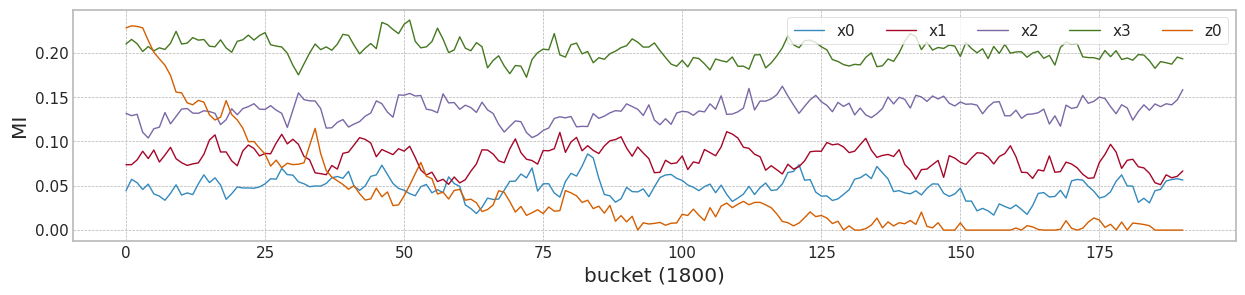

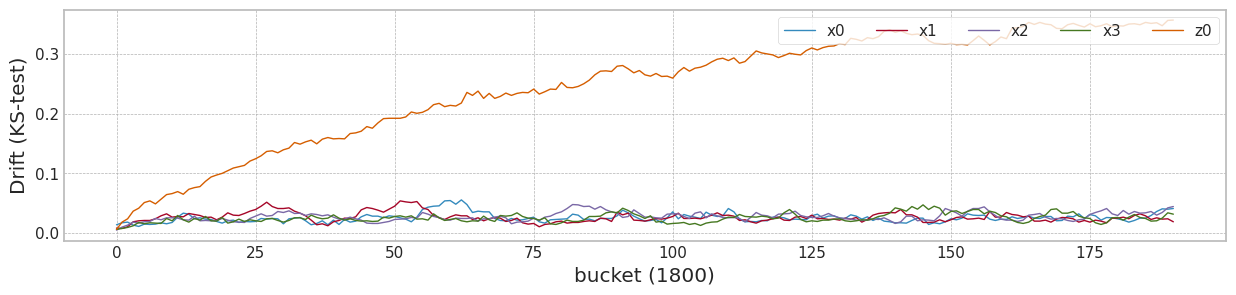

MI Analysis MI Max 0.22806, Min 0.04445, Mean 0.13760, Std 0.07241
cuda:0


100%|██████████| 1000/1000 [00:25<00:00, 39.52it/s]


MSE: 0.23
RMSE: 0.48


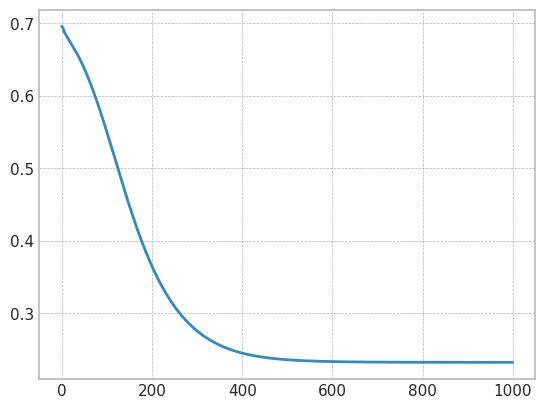

F1 Score:0.90291
Dataset structure X_train, torch.Size([1800, 5]) X_test, torch.Size([1800, 5]) X_live (39800, 5)
Truncate 7200 rows from live_set (39800, 5)


100%|██████████| 191/191 [00:00<00:00, 350.17it/s]


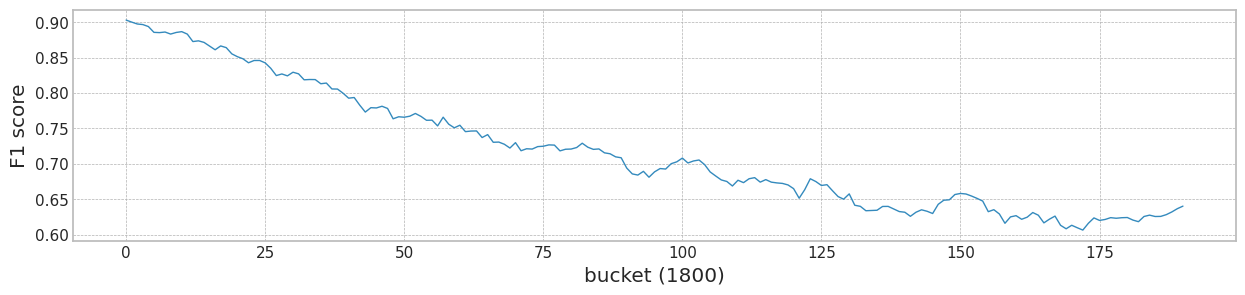

    test_f1   init_f1   mean_f1   last_f1   SUM(MI)
0  0.640502  0.902907  0.717763  0.640502  0.688003


In [144]:
columns=['x0','x1','x2','x3','z0']
X = pd.DataFrame(x,columns=columns)
Y = y

train_size = 1800
test_size = 200

X1,Y1 = check_mi_drift(X, Y,train_size, test_size)
model,df = train_classificaion_model(X1,Y1,train_size, test_size)

In [145]:
X1['b'] = [int(b) for b in X1.index.values/100]
X1

x0        x1        x2        x3        z0    b
0      0.511187  0.348595  0.564807  0.482506  0.395084    0
1      0.435937  0.524656  0.595436  0.762536  0.606272    0
2      0.479071  0.682932  0.738867  0.596141  0.688060    0
3      0.572894  0.251745  0.392850  0.522275  0.344350    0
4      0.562890  0.613393  0.481594  0.596584  0.670729    0
...         ...       ...       ...       ...       ...  ...
39995  0.332800  0.214564  0.468946  0.614324 -0.069684  399
39996  0.414601  0.252607  0.438192  0.601093  0.984518  399
39997  0.361400  0.558191  0.590386  0.612855  0.528420  399
39998  0.459619  0.212723  0.148134  0.664097  2.043499  399
39999  0.647526  0.377718  0.782096  0.629977  1.643125  399

[40000 rows x 6 columns]

lambda_f2 1.0
######################### Lambda -0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:05<00:00, 678.32it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9026258205689278
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 21.13it/s]


mean of drift:
x0    0.025457
x1    0.026437
x2    0.027571
x3    0.025285
z0    0.245739
dtype: float64
Mean F1 for all data: 0.7111527621222895
######################### Lambda 0.0 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 235.88it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9066959385290889
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 20.99it/s]


mean of drift:
x0    1.000000
x1    0.999834
x2    1.000000
x3    0.999936
z0    0.996766
dtype: float64
Mean F1 for all data: 0.7558494782396211
######################### Lambda 0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 235.12it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9042904290429044
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 21.03it/s]


mean of drift:
x0    0.515366
x1    0.860032
x2    0.831425
x3    0.585742
z0    0.410049
dtype: float64
Mean F1 for all data: 0.6957645191602697
######################### Lambda 0.2 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 235.77it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.8967032967032967
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 20.98it/s]


mean of drift:
x0    0.927307
x1    0.318080
x2    0.681425
x3    0.280812
z0    0.336617
dtype: float64
Mean F1 for all data: 0.7024933539701894
######################### Lambda 0.3 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 234.82it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9032967032967033
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 20.27it/s]


mean of drift:
x0    0.143755
x1    0.349953
x2    0.105116
x3    0.200209
z0    0.334971
dtype: float64
Mean F1 for all data: 0.761202780945321
######################### Lambda 0.4 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 239.48it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.8963247394404827
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 19.20it/s]


mean of drift:
x0    0.093714
x1    0.192563
x2    0.249904
x3    0.160553
z0    0.221190
dtype: float64
Mean F1 for all data: 0.8084321122603749
######################### Lambda 0.5 ###########################
cuda:0


100%|██████████| 4000/4000 [00:19<00:00, 207.71it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9021978021978022
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 20.45it/s]


mean of drift:
x0    0.271114
x1    0.296658
x2    0.218592
x3    0.126795
z0    0.405175
dtype: float64
Mean F1 for all data: 0.8031053110525043
######################### Lambda 0.6 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 236.82it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9028006589785831
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 20.96it/s]


mean of drift:
x0    0.120608
x1    0.283825
x2    0.208208
x3    0.113252
z0    0.266225
dtype: float64
Mean F1 for all data: 0.8001565564861661
######################### Lambda 0.7 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 234.60it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9048140043763676
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:10<00:00, 18.81it/s]


mean of drift:
x0    0.131862
x1    0.236143
x2    0.193170
x3    0.078537
z0    0.140727
dtype: float64
Mean F1 for all data: 0.8056833833133501
######################### Lambda 0.8 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 236.44it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9044238121245222
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 19.41it/s]


mean of drift:
x0    0.129159
x1    0.181047
x2    0.141594
x3    0.051393
z0    0.157708
dtype: float64
Mean F1 for all data: 0.7919701021713642
######################### Lambda 0.9 ###########################
cuda:0


100%|██████████| 4000/4000 [00:18<00:00, 221.31it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9051254089422028
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 21.09it/s]


mean of drift:
x0    0.052045
x1    0.123531
x2    0.119122
x3    0.067699
z0    0.217190
dtype: float64
Mean F1 for all data: 0.7586426304198646


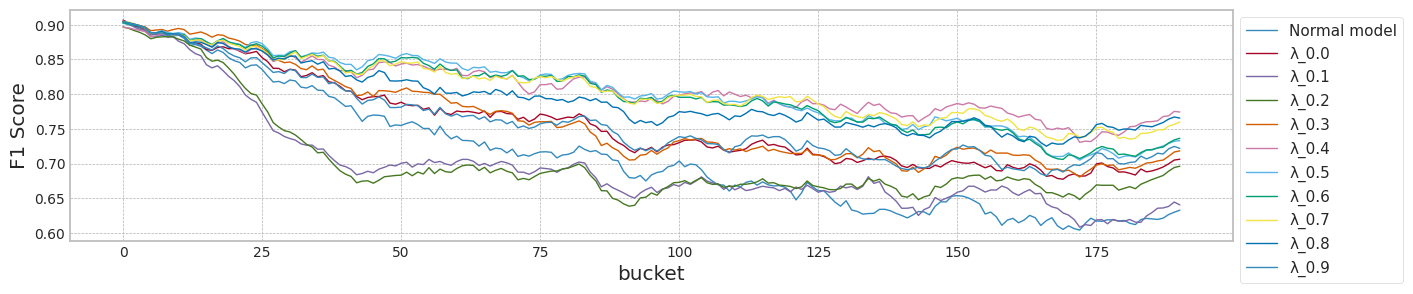

max_mean_lambda= 0.4


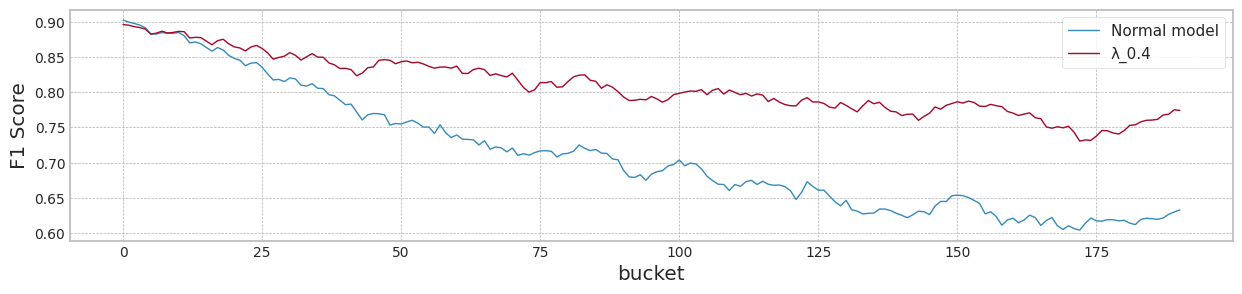

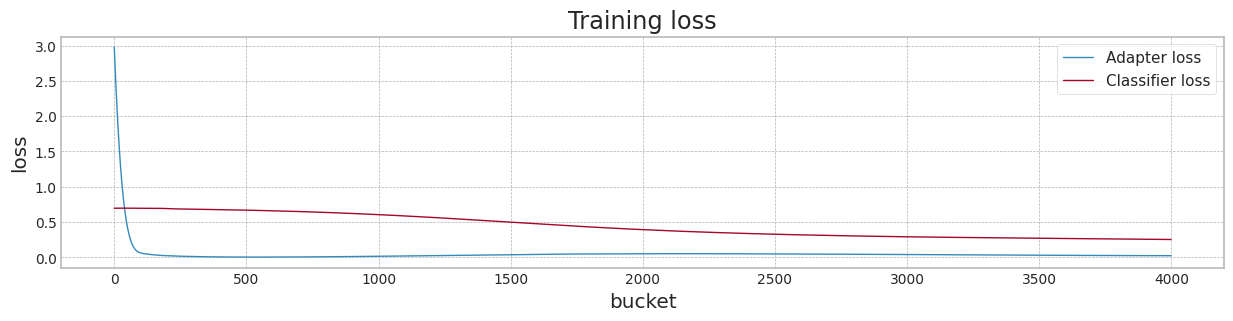

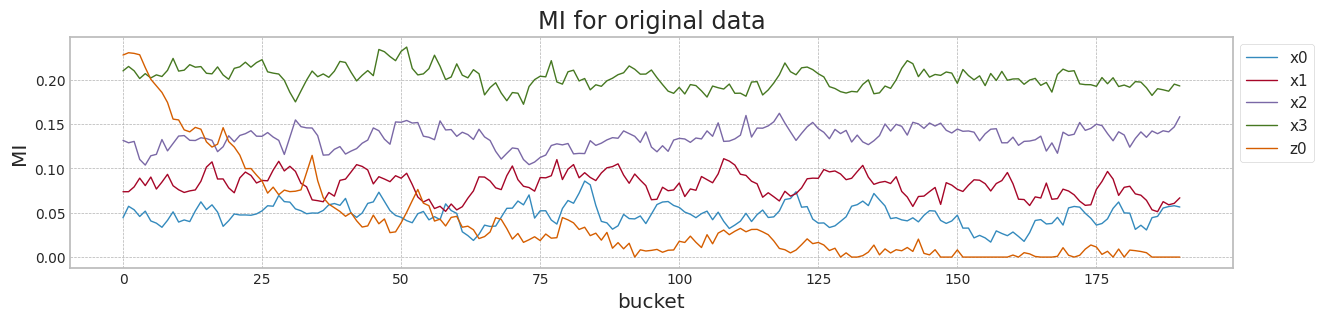

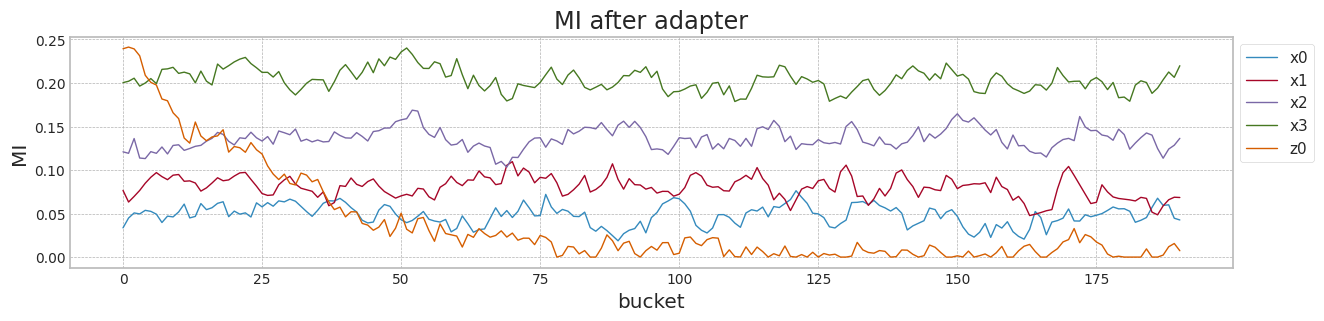

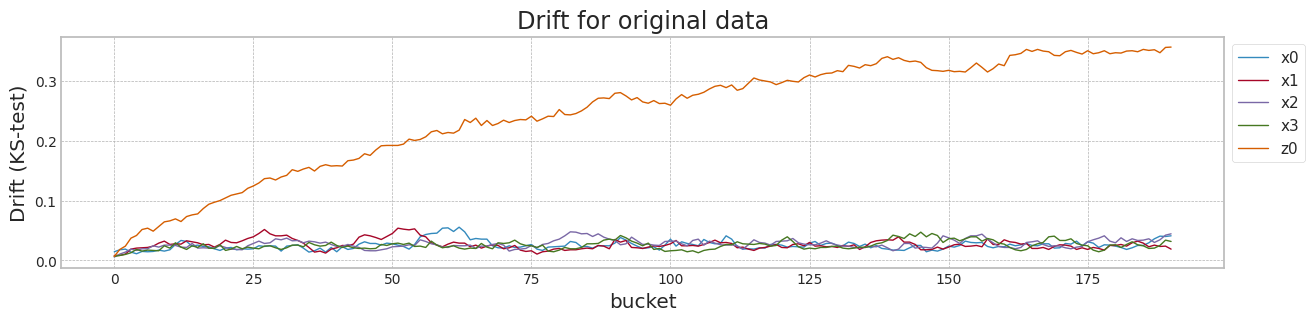

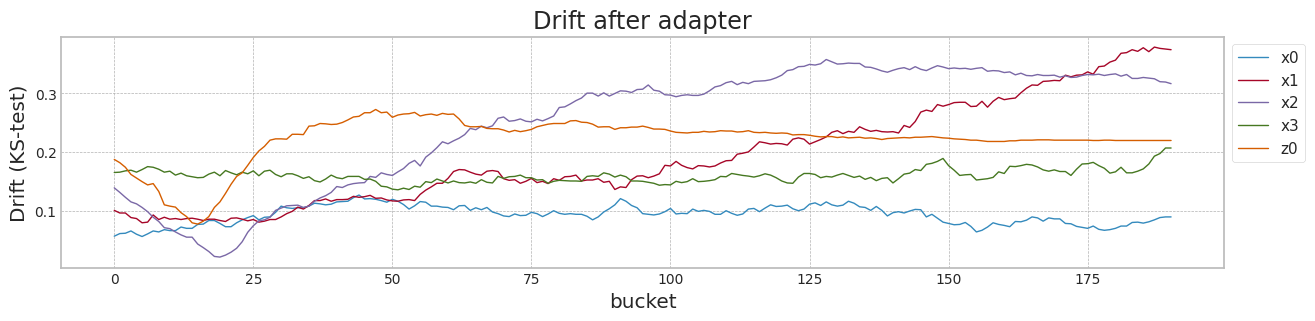

lambda   test_f1   init_f1   mean_f1   last_f1    sum mi  \
0   Case #1, Normal model  0.902626  0.902626  0.711153  0.632739  0.784381   
1                     0.0  0.906696  0.906696  0.755849  0.706171  0.814551   
2                     0.1  0.904290  0.904290  0.695765  0.640413  0.852239   
3                     0.2  0.896703  0.896703  0.702493  0.696125  0.819203   
4                     0.3  0.903297  0.903297  0.761203  0.718257  0.844636   
5                     0.4  0.896325  0.896325  0.808432  0.774194  0.818777   
6                     0.5  0.902198  0.902198  0.803105  0.733028  0.816833   
7                     0.6  0.902801  0.902801  0.800157  0.736395  0.864914   
8                     0.7  0.904814  0.904814  0.805683  0.759759  0.816085   
9                     0.8  0.904424  0.904424  0.791970  0.765454  0.815831   
10                    0.9  0.905125  0.905125  0.758643  0.721751  0.801911   

      std mi  sum * std   sum 1/2   std 1/2   sum 2/2   std 2/2   sum 1-2  \
0   0.095664   0.075037  0.868745  0.118800  0.757712  0.088996  0.111032   
1   0.089406   0.072825  0.861882  0.101852  0.766867  0.086291  0.095015   
2   0.098188   0.083680  0.892185  0.116219  0.764957  0.093210  0.127228   
3   0.097674   0.080015  0.888176  0.123487  0.790313  0.089476  0.097864   
4   0.105152   0.088816  0.878229  0.127789  0.794778  0.095950  0.083451   
5   0.106189   0.086945  0.854381  0.134679  0.773402  0.097194  0.080978   
6   0.103587   0.084614  0.894154  0.120472  0.761836  0.094396  0.132318   
7   0.099898   0.086403  0.896428  0.118920  0.783184  0.092988  0.113244   
8   0.094792   0.077358  0.882960  0.120480  0.762021  0.095827  0.120939   
9   0.103108   0.084119  0.883571  0.119064  0.772245  0.100209  0.111326   
10  0.099079   0.079453  0.874274  0.123085  0.747326  0.096681  0.126948   

     std 1-2   sum 1+2   std 1+2  
0   0.029804  1.626457  0.207796  
1   0.015561  1.628748  0.188144  
2   0.023009  1.657142  0.209428  
3   0.034011  1.678489  0.212963  
4   0.031839  1.673007  0.223739  
5   0.037485  1.627783  0.231873  
6   0.026077  1.655989  0.214868  
7   0.025932  1.679611  0.211908  
8   0.024653  1.644981  0.216307  
9   0.018855  1.655816  0.219273  
10  0.026404  1.621600  0.219766

In [146]:
drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 400)

## synthetic data의 생성 (Case #2 MI의 증감(상대적), Drift의 고정)

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature에 대해 y의 비중이 시간에 따라 감소하도록 생성

### Dataset 준비

In [132]:
data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 2.5])

In [133]:
seed_everything()

x1 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x1[:,ix] = np.random.normal(1,cor_,data_size)

In [134]:
x1.shape

(40000, 5)

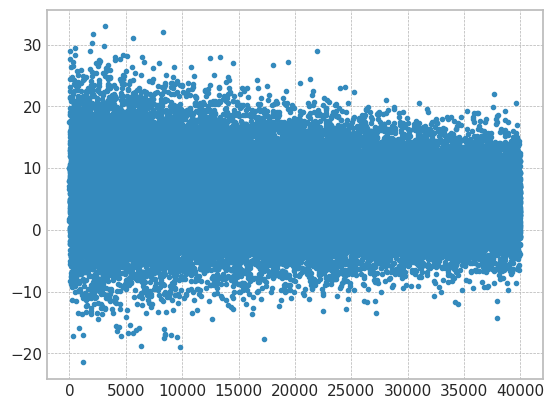

In [135]:
import matplotlib.pyplot as plt

seed_everything()

y1_array = []
cor_const = cor[4]
for ii in range(x1.shape[0]):
    cor[4] = cor[4] - cor_const / x1.shape[0]
    e = np.random.normal(0.0, 2.0)
    y1_array.append(np.sum(cor * x1[ii])+e)

plt.plot(y1_array,'.')

In [136]:
m = 5 #np.mean(y1_array[0:2000])
print(m)
y1 = [1 if y_ > m else 0 for y_ in y1_array]
print(sum(y1))

5
21325


### 실험

MI Analysis MI Max 0.22746, Min 0.00677, Mean 0.06988, Std 0.08433
Dataset structure X_train, (1800, 5) X_test, (1800, 5) X_live (39800, 5)
Truncate 7200 rows from live_set (39800, 5)
Search MI & Drift...for X_live_set (191, 1800, 5)


100%|██████████| 191/191 [00:08<00:00, 22.67it/s]


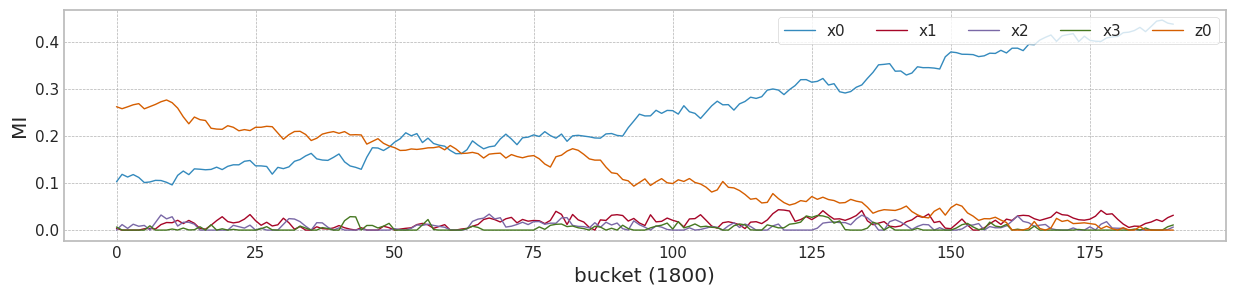

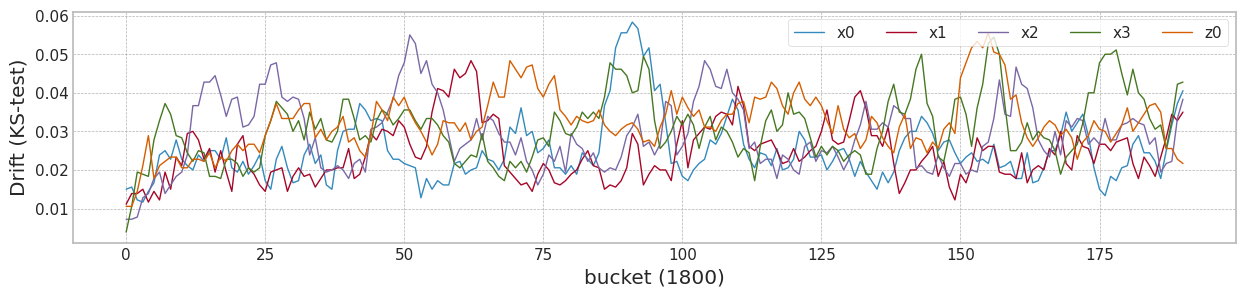

MI Analysis MI Max 0.26184, Min 0.00000, Mean 0.07488, Std 0.10109
cuda:0


100%|██████████| 1000/1000 [00:25<00:00, 39.48it/s]


MSE: 0.05
RMSE: 0.23


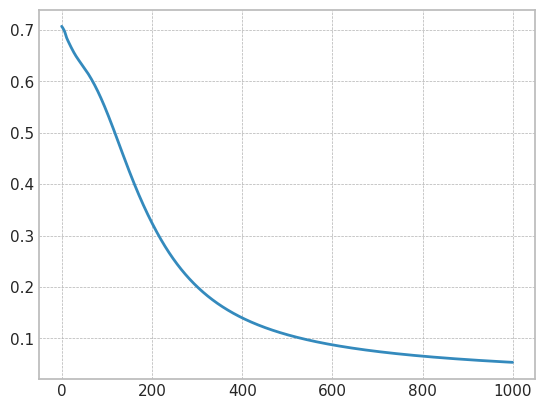

F1 Score:0.99568
Dataset structure X_train, torch.Size([1800, 5]) X_test, torch.Size([1800, 5]) X_live (39800, 5)
Truncate 7200 rows from live_set (39800, 5)


100%|██████████| 191/191 [00:00<00:00, 370.97it/s]


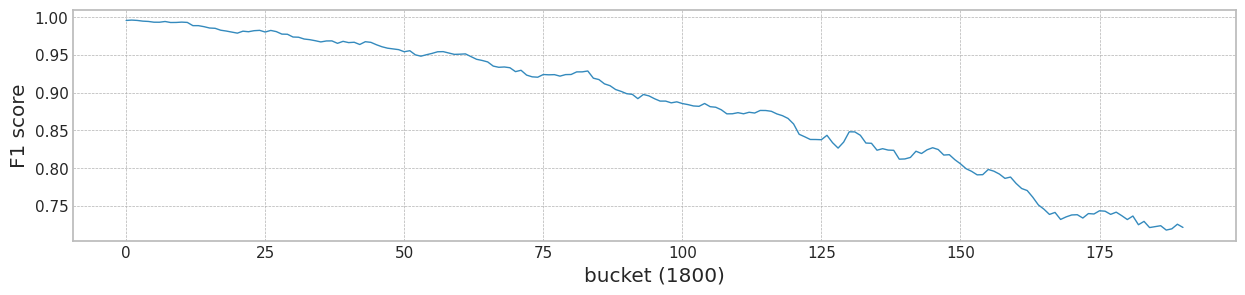

    test_f1   init_f1   mean_f1   last_f1   SUM(MI)
0  0.721577  0.995679  0.882188  0.721577  0.374413


In [137]:
columns=['x0','x1','x2','x3','z0']
X1 = pd.DataFrame(x1,columns=columns)

train_size = 1800
test_size = 200

X1,Y1 = check_mi_drift(X1, y1,train_size, test_size)
model,df = train_classificaion_model(X1,Y1,train_size, test_size)

In [138]:
X1['b'] = [int(b/100) for b in X1.index.values]
X1

x0        x1        x2        x3        z0    b
0      0.519751  0.468030  0.270011  0.516605  0.339159    0
1      0.605565  0.386136  0.467312  0.549700  0.666164    0
2      0.551222  0.433079  0.644682  0.704678  0.471856    0
3      0.335978  0.625620  0.283118  0.494381  0.609888    0
4      0.496805  0.524298  0.566753  0.426693  0.472373    0
...         ...       ...       ...       ...       ...  ...
39995  0.325122  0.364328  0.241452  0.576603  0.717378  399
39996  0.350268  0.453351  0.284085  0.543373  0.701927  399
39997  0.553850  0.305018  0.504892  0.544244  0.491374  399
39998  0.426469  0.502344  0.239389  0.229965  0.775500  399
39999  0.532744  0.616406  0.302647  0.751387  0.511368  399

[40000 rows x 6 columns]

lambda_f2 1.0
######################### Lambda -0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 666.00it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9721040189125295
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 21.18it/s]


mean of drift:
x0    0.024977
x1    0.024340
x2    0.029145
x3    0.030794
z0    0.032225
dtype: float64
Mean F1 for all data: 0.8643210537736058
######################### Lambda 0.0 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 235.45it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9975973089860644
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 20.81it/s]


mean of drift:
x0    0.999482
x1    0.931070
x2    1.000000
x3    1.000000
z0    0.927472
dtype: float64
Mean F1 for all data: 0.8870357625076744
######################### Lambda 0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 233.65it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9856459330143541
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 20.75it/s]


mean of drift:
x0    0.931908
x1    0.679625
x2    0.573586
x3    0.193743
z0    0.560428
dtype: float64
Mean F1 for all data: 0.15868813221506423
######################### Lambda 0.2 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 235.19it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9832615973218555
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 21.01it/s]


mean of drift:
x0    0.918691
x1    0.477944
x2    0.327708
x3    0.057109
z0    0.641527
dtype: float64
Mean F1 for all data: 0.15924157352318605
######################### Lambda 0.3 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 237.60it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9677113010446343
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 21.28it/s]


mean of drift:
x0    0.913232
x1    0.128016
x2    0.104331
x3    0.057877
z0    0.612664
dtype: float64
Mean F1 for all data: 0.1586350816666022
######################### Lambda 0.4 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 233.55it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9672830725462305
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 20.93it/s]


mean of drift:
x0    0.885756
x1    0.175829
x2    0.044159
x3    0.071626
z0    0.422551
dtype: float64
Mean F1 for all data: 0.18072012959471526
######################### Lambda 0.5 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 235.52it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9654846335697399
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 21.04it/s]


mean of drift:
x0    0.869779
x1    0.086044
x2    0.061382
x3    0.056885
z0    0.382618
dtype: float64
Mean F1 for all data: 0.195212684530298
######################### Lambda 0.6 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 235.12it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9632075471698113
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 21.02it/s]


mean of drift:
x0    0.421341
x1    0.056184
x2    0.047059
x3    0.054607
z0    0.357580
dtype: float64
Mean F1 for all data: 0.9067667133889591
######################### Lambda 0.7 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 232.73it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.959135744480977
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 21.47it/s]


mean of drift:
x0    0.262205
x1    0.068898
x2    0.065416
x3    0.052150
z0    0.180800
dtype: float64
Mean F1 for all data: 0.9116671658173018
######################### Lambda 0.8 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 233.45it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9573370839193623
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 21.33it/s]


mean of drift:
x0    0.116672
x1    0.079703
x2    0.084398
x3    0.050442
z0    0.138258
dtype: float64
Mean F1 for all data: 0.8975687557261782
######################### Lambda 0.9 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 238.03it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9579045837231058
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 20.93it/s]


mean of drift:
x0    0.109465
x1    0.093938
x2    0.090334
x3    0.049302
z0    0.115023
dtype: float64
Mean F1 for all data: 0.8398416414342023


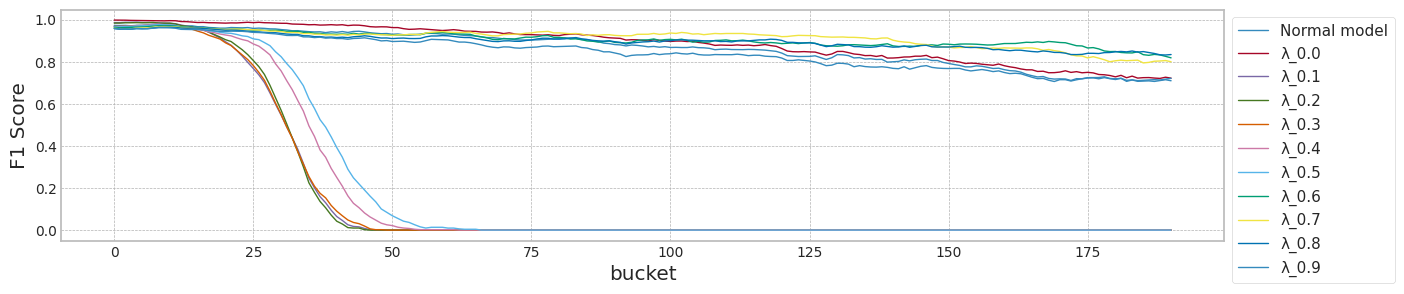

max_mean_lambda= 0.7


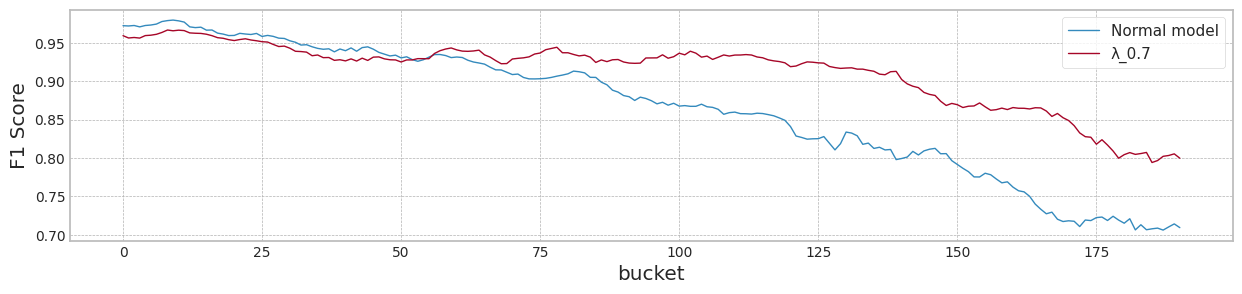

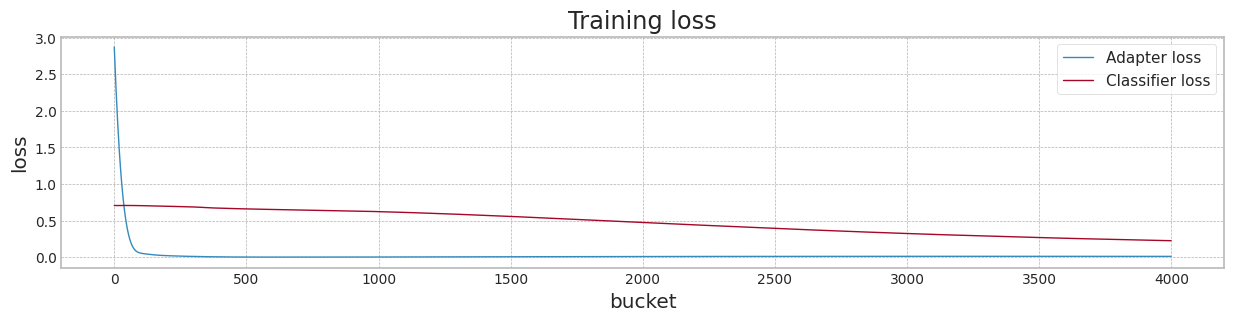

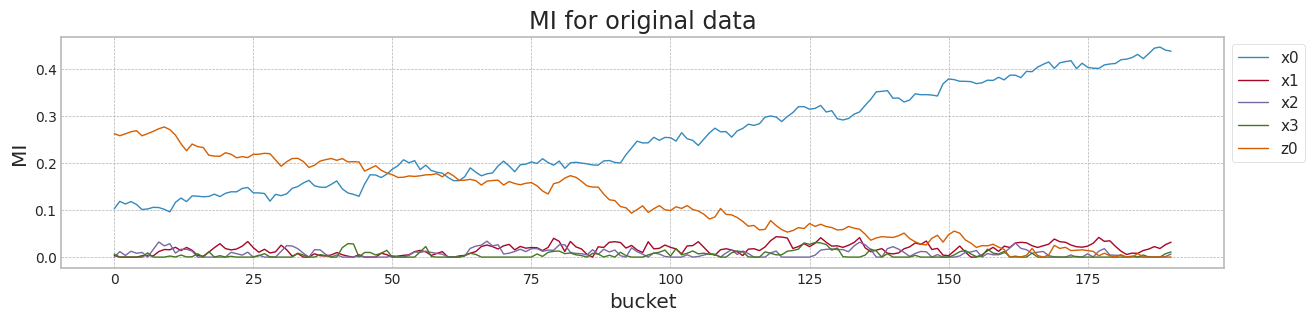

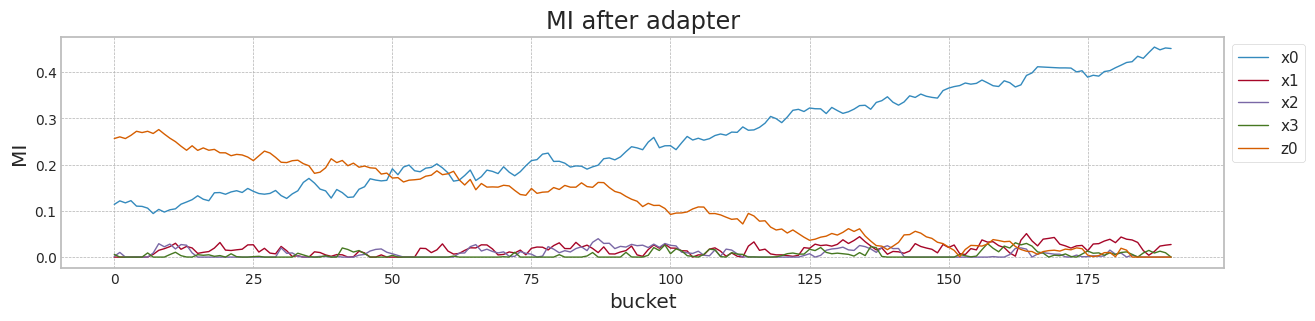

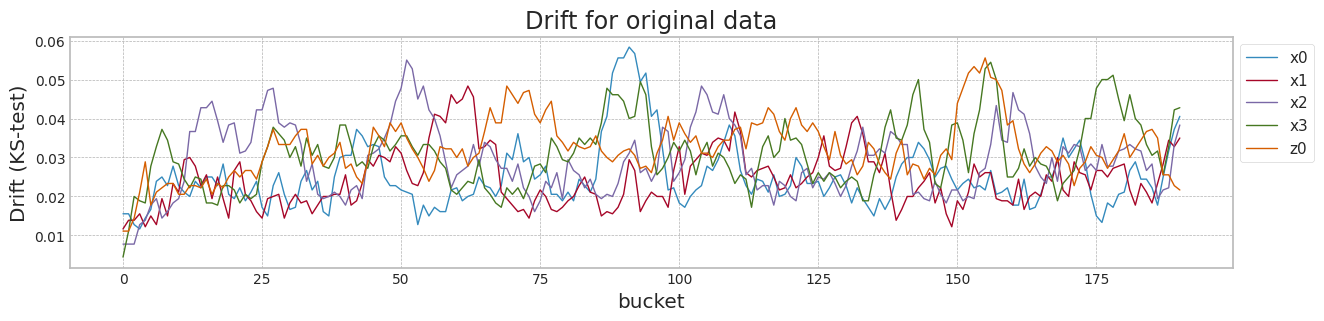

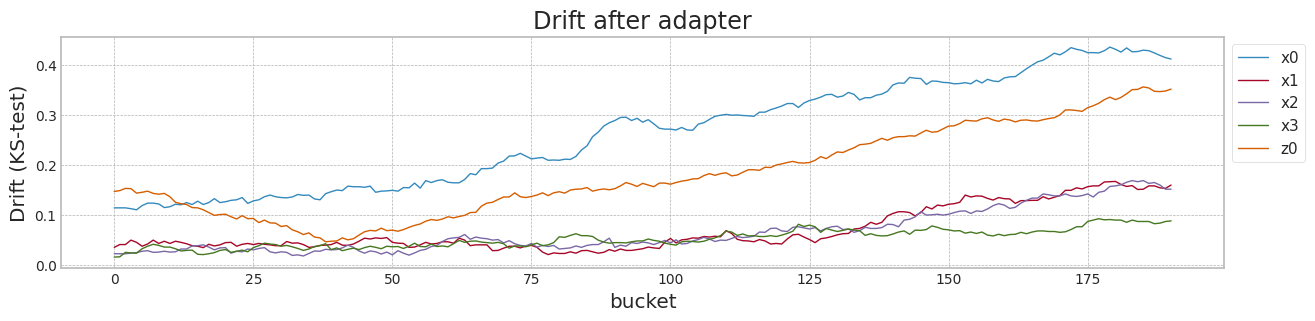

lambda   test_f1   init_f1   mean_f1   last_f1    sum mi  \
0   Case #1, Normal model  0.972104  0.972104  0.864321  0.709419  0.404505   
1                     0.0  0.997597  0.997597  0.887036  0.721821  0.370629   
2                     0.1  0.985646  0.985646  0.158688  0.000000  0.401831   
3                     0.2  0.983262  0.983262  0.159242  0.000000  0.408573   
4                     0.3  0.967711  0.967711  0.158635  0.000000  0.402801   
5                     0.4  0.967283  0.967283  0.180720  0.000000  0.421404   
6                     0.5  0.965485  0.965485  0.195213  0.000000  0.407084   
7                     0.6  0.963208  0.963208  0.906767  0.818243  0.416524   
8                     0.7  0.959136  0.959136  0.911667  0.799734  0.401247   
9                     0.8  0.957337  0.957337  0.897569  0.833905  0.411121   
10                    0.9  0.957905  0.957905  0.839842  0.721094  0.396822   

      std mi  sum * std   sum 1/2   std 1/2   sum 2/2   std 2/2   sum 1-2  \
0   0.116157   0.046986  0.416156  0.110673  0.386578  0.111651  0.029578   
1   0.104103   0.038584  0.421088  0.104228  0.343198  0.100045  0.077891   
2   0.107853   0.043339  0.435864  0.110391  0.339103  0.098538  0.096761   
3   0.106174   0.043380  0.447761  0.116203  0.348950  0.098824  0.098810   
4   0.107321   0.043229  0.436969  0.117830  0.351481  0.106578  0.085488   
5   0.113381   0.047779  0.430117  0.117441  0.381597  0.108525  0.048520   
6   0.114994   0.046812  0.438454  0.116854  0.385245  0.110210  0.053209   
7   0.119461   0.049759  0.431245  0.118903  0.391510  0.112134  0.039735   
8   0.111051   0.044559  0.421789  0.121213  0.381428  0.111702  0.040360   
9   0.114381   0.047024  0.411285  0.118191  0.391412  0.117440  0.019873   
10  0.112169   0.044511  0.398597  0.113156  0.385943  0.112739  0.012654   

     std 1-2   sum 1+2   std 1+2  
0   0.000978  0.802734  0.222325  
1   0.004183  0.764286  0.204273  
2   0.011853  0.774967  0.208929  
3   0.017379  0.796711  0.215027  
4   0.011253  0.788450  0.224408  
5   0.008916  0.811715  0.225967  
6   0.006644  0.823699  0.227065  
7   0.006769  0.822755  0.231037  
8   0.009511  0.803217  0.232916  
9   0.000751  0.802697  0.235631  
10  0.000417  0.784540  0.225895

In [140]:
drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 400)

## synthetic data의 생성 (Case #3 MI의 증감(상대적), Drift의 증가)

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 data drift, MI는 고정

### Dataset 준비

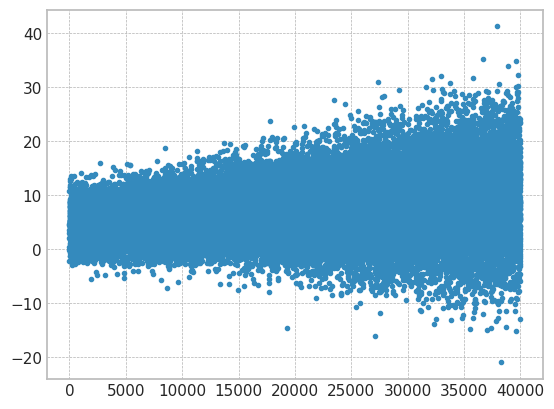

In [125]:
import matplotlib.pyplot as plt

seed_everything(2)

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 0.5])

x2 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x2[:,ix] = np.random.normal(1,cor_,data_size)

y2_array = []
cor_const = 3/x2.shape[0]
for ii in range(x2.shape[0]):
    e = np.random.normal(0.0+10*ii/40000, 5*cor_const * ii)
    e1 = 0.0 #np.random.normal(0.0, cor_const * ii)
    x2[ii,4] = x2[ii,4] + e
    y2_array.append(np.sum(cor * x2[ii])+e1)

plt.plot(y2_array,'.')

In [126]:
m = 5 #np.mean(y2_array)
print(m)
y2 = [1 if y_ > m else 0 for y_ in y2_array]
sum(y2)

5


26135

### 실험

MI Analysis MI Max 0.22487, Min 0.00191, Mean 0.07138, Std 0.08241
Dataset structure X_train, (1800, 5) X_test, (1800, 5) X_live (39800, 5)
Truncate 7200 rows from live_set (39800, 5)
Search MI & Drift...for X_live_set (191, 1800, 5)


100%|██████████| 191/191 [00:08<00:00, 22.89it/s]


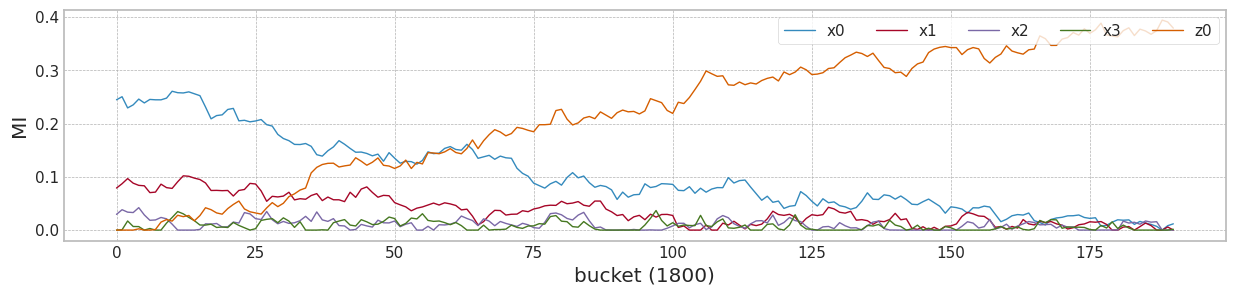

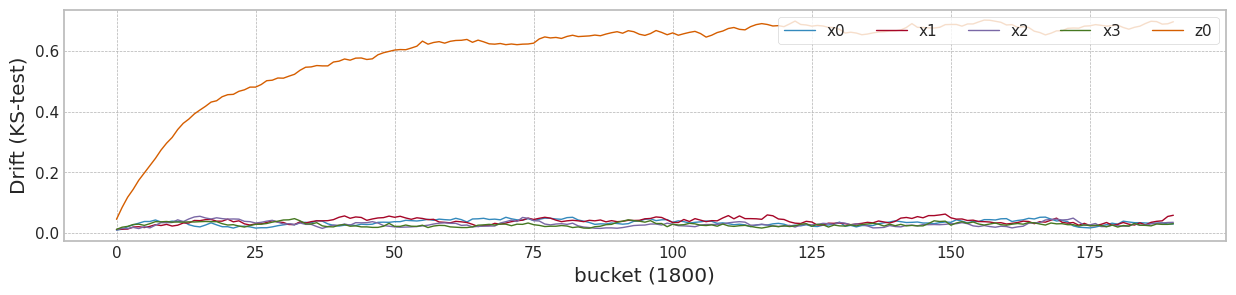

In [127]:
columns=['x0','x1','x2','x3','z0']
X2 = pd.DataFrame(x2,columns=columns)

train_size = 1800
test_size = 200

X1,Y1 = check_mi_drift(X2, y2,train_size, test_size)

In [128]:
X1['b'] = [int(b/100) for b in X1.index.values]
X1

x0        x1        x2        x3        z0    b
0      0.391378  0.179737  0.412932  0.754981  0.336829    0
1      0.439860  0.516005  0.490105  0.540805  0.398226    0
2      0.160132  0.417404  0.389905  0.423808  0.347760    0
3      0.668025  0.621269  0.663604  0.508593  0.540260    0
4      0.206230  0.473113  0.366847  0.584109  0.361078    0
...         ...       ...       ...       ...       ...  ...
39995  0.321563  0.552908  0.399885  0.610627  3.089269  399
39996  0.380574  0.622177  0.454242  0.441404  0.777635  399
39997  0.370265  0.491261  0.156487  0.514722  5.363135  399
39998  0.388943  0.572886  0.872513  0.683365 -0.954199  399
39999  0.406888  0.446354  0.462540  0.510277  0.229368  399

[40000 rows x 6 columns]

lambda_f2 1.0
######################### Lambda -0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 665.26it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9579735175590097
Sum of MI = 0.35790
Std of MI = 0.09469
Sum of MI A = 0.40110
Std of MI A = 0.09567
Sum of MI B = 0.37296
Std of MI B = 0.09991
ABS(sum(A-B)) = 0.02814
ABS(std(A-B)) = 0.00424
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 21.70it/s]


mean of drift:
x0    0.033307
x1    0.038115
x2    0.028214
x3    0.026774
z0    0.603037
dtype: float64
Mean F1 for all data: 0.8797823750368523
######################### Lambda 0.0 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 231.50it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.998282770463652
Sum of MI = 0.35160
Std of MI = 0.09042
Sum of MI A = 0.39693
Std of MI A = 0.08635
Sum of MI B = 0.38227
Std of MI B = 0.09092
ABS(sum(A-B)) = 0.01466
ABS(std(A-B)) = 0.00457
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 19.55it/s]


mean of drift:
x0    0.674005
x1    0.818988
x2    1.000000
x3    1.000000
z0    0.847339
dtype: float64
Mean F1 for all data: 0.9528524304249364
######################### Lambda 0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 237.08it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9914236706689536
Sum of MI = 0.35024
Std of MI = 0.09136
Sum of MI A = 0.36999
Std of MI A = 0.08343
Sum of MI B = 0.34844
Std of MI B = 0.09935
ABS(sum(A-B)) = 0.02156
ABS(std(A-B)) = 0.01592
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 21.18it/s]


mean of drift:
x0    0.780442
x1    0.875780
x2    0.796216
x3    0.630160
z0    0.585567
dtype: float64
Mean F1 for all data: 0.1690171622774794
######################### Lambda 0.2 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 234.31it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9908571428571428
Sum of MI = 0.38662
Std of MI = 0.08519
Sum of MI A = 0.42713
Std of MI A = 0.08526
Sum of MI B = 0.37732
Std of MI B = 0.09997
ABS(sum(A-B)) = 0.04981
ABS(std(A-B)) = 0.01471
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 21.47it/s]


mean of drift:
x0    0.346940
x1    0.933781
x2    0.297539
x3    0.527455
z0    0.603333
dtype: float64
Mean F1 for all data: 0.13516616883732294
######################### Lambda 0.3 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 234.06it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9787965616045845
Sum of MI = 0.42259
Std of MI = 0.09219
Sum of MI A = 0.46906
Std of MI A = 0.09230
Sum of MI B = 0.38056
Std of MI B = 0.10403
ABS(sum(A-B)) = 0.08850
ABS(std(A-B)) = 0.01173
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 21.49it/s]


mean of drift:
x0    0.803697
x1    0.887565
x2    0.251370
x3    0.449881
z0    0.878330
dtype: float64
Mean F1 for all data: 0.12109488886479948
######################### Lambda 0.4 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 234.83it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9781859931113663
Sum of MI = 0.40333
Std of MI = 0.09770
Sum of MI A = 0.43548
Std of MI A = 0.08955
Sum of MI B = 0.38151
Std of MI B = 0.10323
ABS(sum(A-B)) = 0.05397
ABS(std(A-B)) = 0.01368
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 20.95it/s]


mean of drift:
x0    0.836515
x1    0.826687
x2    0.093214
x3    0.400939
z0    0.790224
dtype: float64
Mean F1 for all data: 0.12239061155987946
######################### Lambda 0.5 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 236.41it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9662664379645513
Sum of MI = 0.45893
Std of MI = 0.10515
Sum of MI A = 0.45467
Std of MI A = 0.09181
Sum of MI B = 0.40365
Std of MI B = 0.11493
ABS(sum(A-B)) = 0.05102
ABS(std(A-B)) = 0.02312
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 20.84it/s]


mean of drift:
x0    0.773304
x1    0.803490
x2    0.198758
x3    0.359776
z0    0.935669
dtype: float64
Mean F1 for all data: 0.13369274978244644
######################### Lambda 0.6 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 234.41it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.950517836593786
Sum of MI = 0.39844
Std of MI = 0.10659
Sum of MI A = 0.41940
Std of MI A = 0.09590
Sum of MI B = 0.39408
Std of MI B = 0.11128
ABS(sum(A-B)) = 0.02532
ABS(std(A-B)) = 0.01538
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 21.40it/s]


mean of drift:
x0    0.749092
x1    0.737525
x2    0.349948
x3    0.342670
z0    0.938432
dtype: float64
Mean F1 for all data: 0.14355654962851916
######################### Lambda 0.7 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 235.94it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9365351629502574
Sum of MI = 0.38972
Std of MI = 0.11109
Sum of MI A = 0.40842
Std of MI A = 0.10175
Sum of MI B = 0.41289
Std of MI B = 0.11852
ABS(sum(A-B)) = 0.00448
ABS(std(A-B)) = 0.01678
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 21.29it/s]


mean of drift:
x0    0.686611
x1    0.724311
x2    0.269186
x3    0.154636
z0    0.618266
dtype: float64
Mean F1 for all data: 0.1904979426323827
######################### Lambda 0.8 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 237.25it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9399656946826758
Sum of MI = 0.39281
Std of MI = 0.11530
Sum of MI A = 0.40451
Std of MI A = 0.10736
Sum of MI B = 0.38636
Std of MI B = 0.11909
ABS(sum(A-B)) = 0.01815
ABS(std(A-B)) = 0.01173
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 21.17it/s]


mean of drift:
x0    0.562248
x1    0.491393
x2    0.261955
x3    0.097350
z0    0.601111
dtype: float64
Mean F1 for all data: 0.29037648673435684
######################### Lambda 0.9 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 236.77it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.94346087949743
Sum of MI = 0.38702
Std of MI = 0.10746
Sum of MI A = 0.38150
Std of MI A = 0.10152
Sum of MI B = 0.38558
Std of MI B = 0.11760
ABS(sum(A-B)) = 0.00408
ABS(std(A-B)) = 0.01608
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 21.25it/s]


mean of drift:
x0    0.199142
x1    0.298650
x2    0.210963
x3    0.062586
z0    0.599604
dtype: float64
Mean F1 for all data: 0.8593559601645586


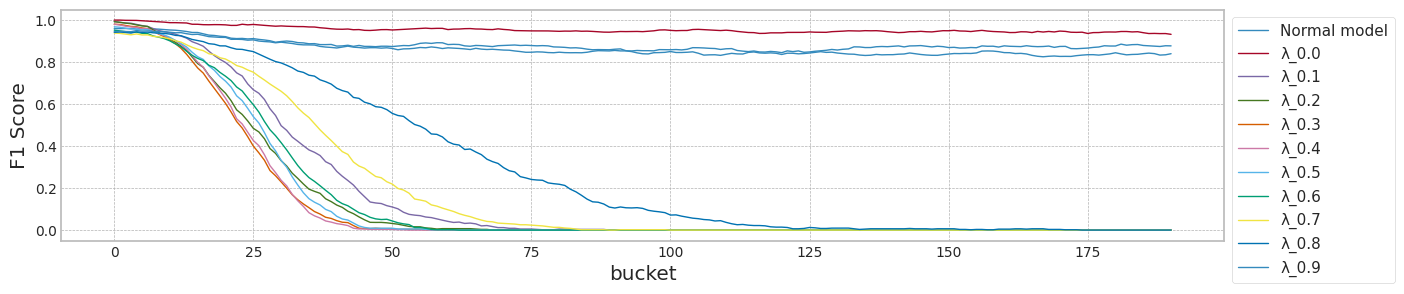

max_mean_lambda= 0.0


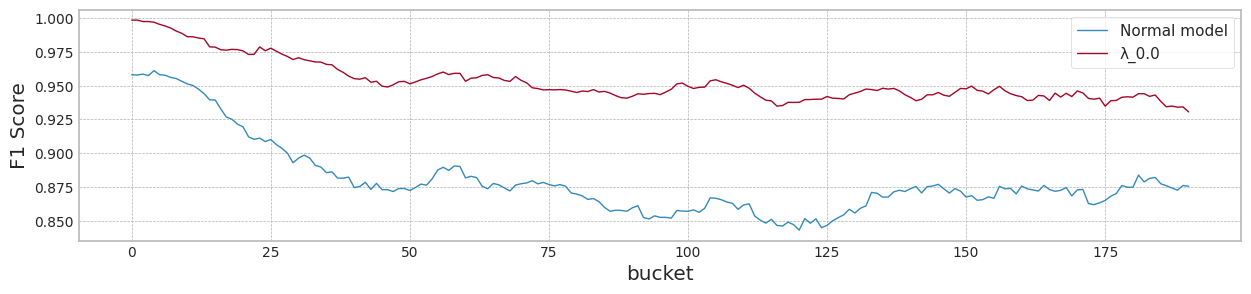

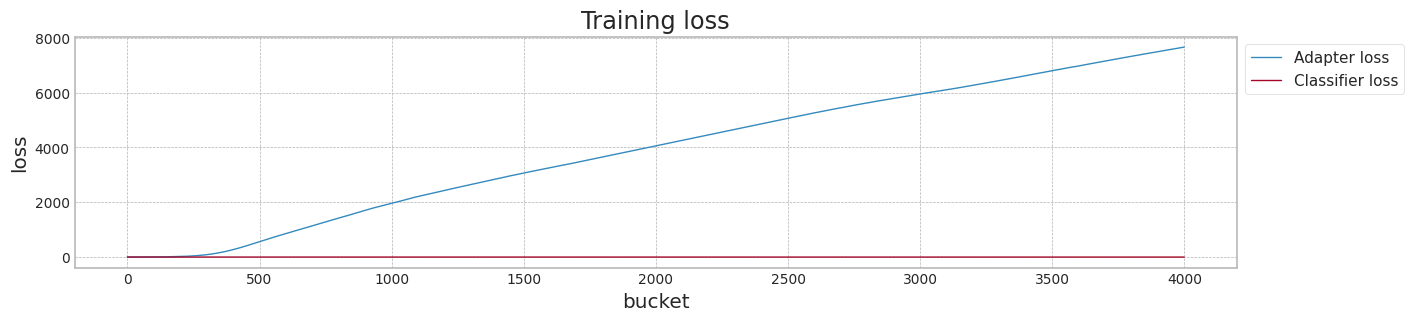

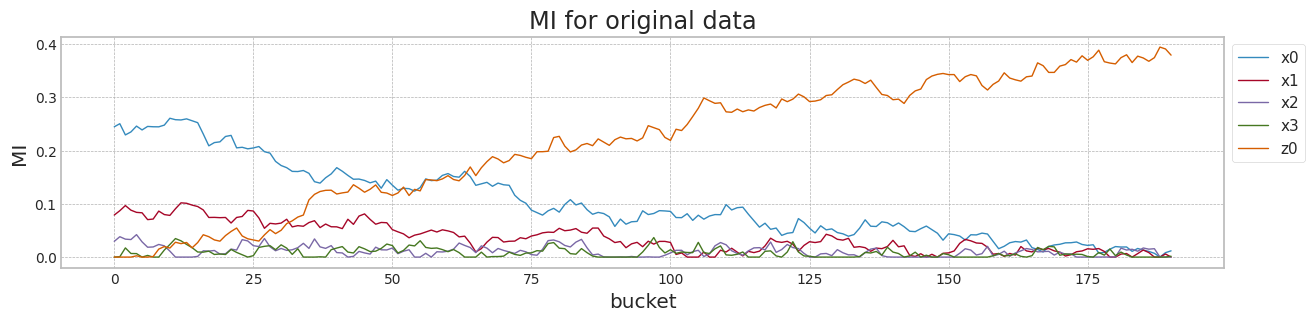

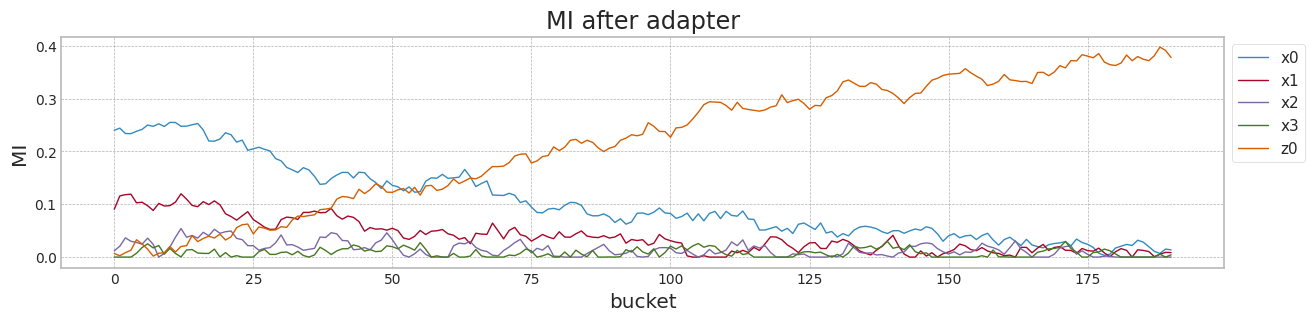

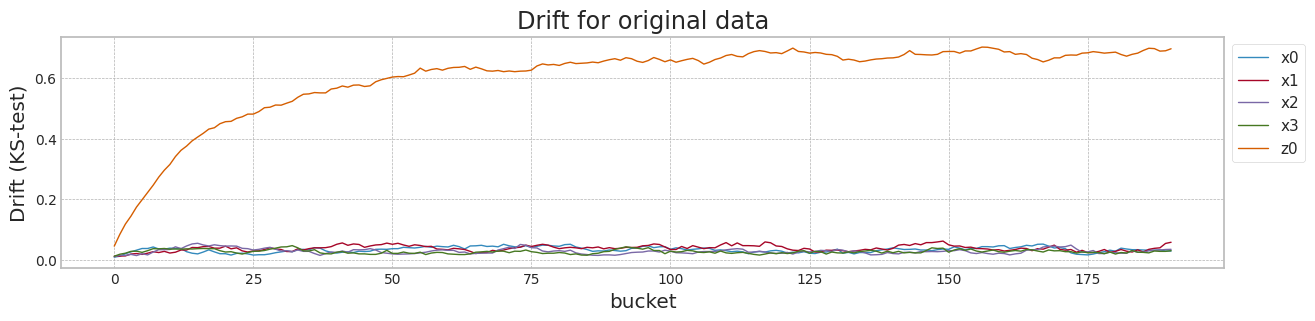

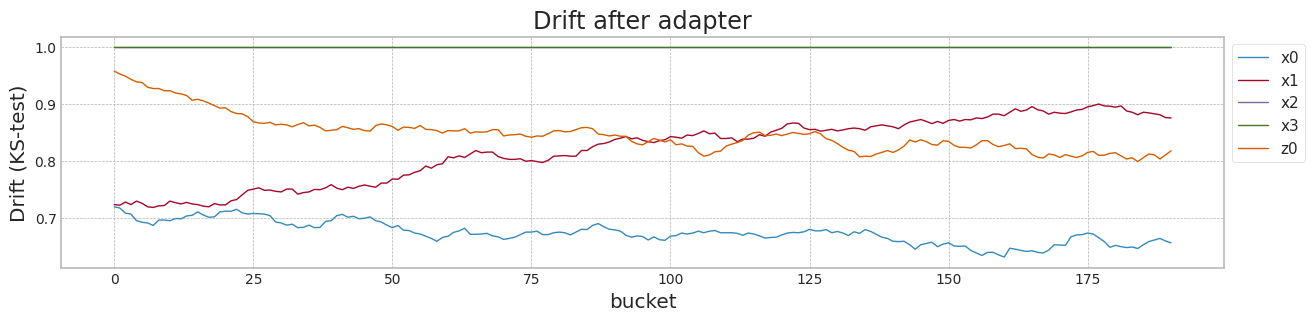

lambda   test_f1   init_f1   mean_f1   last_f1    sum mi  \
0   Case #1, Normal model  0.957974  0.957974  0.879782  0.875745  0.357895   
1                     0.0  0.998283  0.998283  0.952852  0.930595  0.351602   
2                     0.1  0.991424  0.991424  0.169017  0.000000  0.350236   
3                     0.2  0.990857  0.990857  0.135166  0.000000  0.386619   
4                     0.3  0.978797  0.978797  0.121095  0.000000  0.422595   
5                     0.4  0.978186  0.978186  0.122391  0.000000  0.403333   
6                     0.5  0.966266  0.966266  0.133693  0.000000  0.458925   
7                     0.6  0.950518  0.950518  0.143557  0.000000  0.398440   
8                     0.7  0.936535  0.936535  0.190498  0.000000  0.389722   
9                     0.8  0.939966  0.939966  0.290376  0.000000  0.392811   
10                    0.9  0.943461  0.943461  0.859356  0.838479  0.387018   

      std mi  sum * std   sum 1/2   std 1/2   sum 2/2   std 2/2   sum 1-2  \
0   0.094693   0.033890  0.401104  0.095670  0.372965  0.099913  0.028139   
1   0.090419   0.031791  0.396926  0.086352  0.382269  0.090925  0.014657   
2   0.091358   0.031997  0.369992  0.083432  0.348436  0.099351  0.021556   
3   0.085195   0.032938  0.427131  0.085257  0.377320  0.099966  0.049810   
4   0.092190   0.038959  0.469056  0.092300  0.380558  0.104031  0.088498   
5   0.097698   0.039405  0.435476  0.089550  0.381507  0.103231  0.053969   
6   0.105146   0.048254  0.454672  0.091806  0.403650  0.114925  0.051022   
7   0.106593   0.042471  0.419404  0.095902  0.394085  0.111279  0.025319   
8   0.111091   0.043294  0.408418  0.101746  0.412895  0.118524  0.004477   
9   0.115296   0.045290  0.404514  0.107361  0.386361  0.119087  0.018153   
10  0.107462   0.041590  0.381496  0.101516  0.385580  0.117598  0.004084   

     std 1-2   sum 1+2   std 1+2  
0   0.004242  0.774068  0.195583  
1   0.004573  0.779196  0.177277  
2   0.015918  0.718429  0.182783  
3   0.014709  0.804451  0.185224  
4   0.011731  0.849614  0.196330  
5   0.013681  0.816983  0.192781  
6   0.023119  0.858322  0.206732  
7   0.015377  0.813488  0.207181  
8   0.016777  0.821312  0.220270  
9   0.011726  0.790874  0.226448  
10  0.016082  0.767076  0.219115

In [130]:
drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 400)

## synthetic data의 생성 (Case #4 MI의 고정, Drift의 증가)

### Dataset 준비

In [111]:
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 0.5])

y3= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x3 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    '''
    x3[:,ix] = y3 + np.random.normal(1,cor_,data_size)
    '''
    # z0
    if ix == 4:
        for ii in range(len(y3)):
            x3[ii,ix] = y3[ii] + np.random.normal(0.0 + 4*ii/data_size,cor_)
    else:
        x3[:,ix] = y3 + np.random.normal(1,cor_,data_size)


### 실험

MI Analysis MI Max 0.20278, Min 0.05089, Mean 0.11172, Std 0.05282
Dataset structure X_train, (1800, 5) X_test, (1800, 5) X_live (39800, 5)
Truncate 7200 rows from live_set (39800, 5)
Search MI & Drift...for X_live_set (191, 1800, 5)


100%|██████████| 191/191 [00:08<00:00, 21.31it/s]


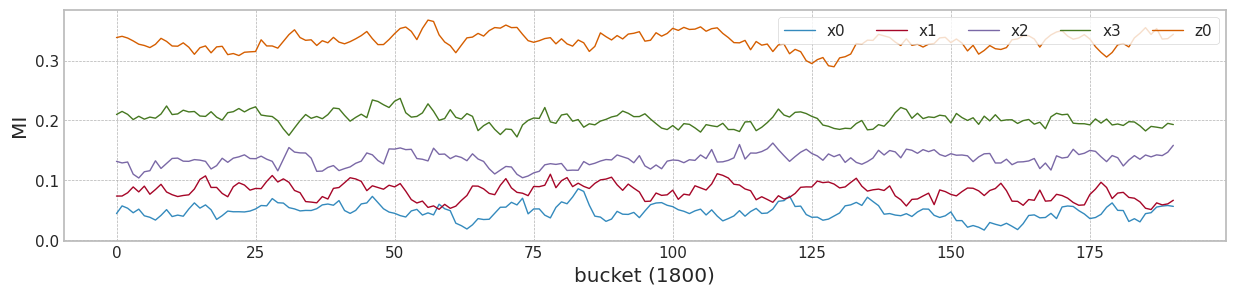

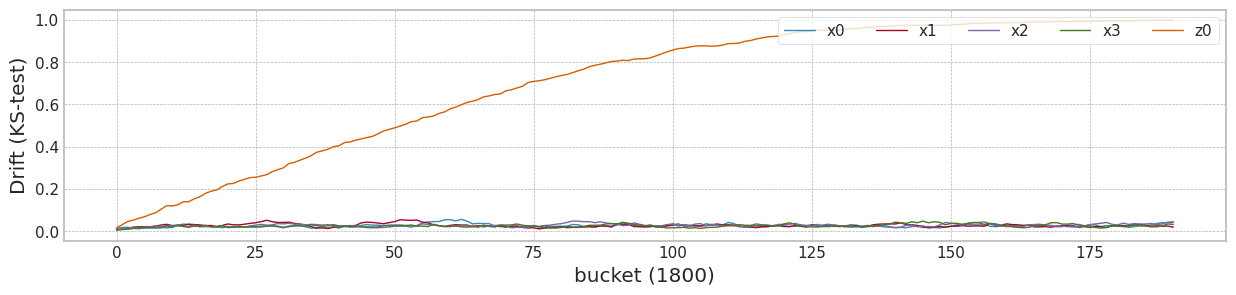

In [112]:
columns=['x0','x1','x2','x3','z0']
X3 = pd.DataFrame(x3,columns=columns)

train_size = 1800
test_size = 200

X1,Y1 = check_mi_drift(X3, y3,train_size, test_size)

In [113]:
X1['b'] = [int(b/100) for b in X1.index.values]
X1

x0        x1        x2        x3        z0    b
0      0.511187  0.348595  0.564807  0.482506  0.503588    0
1      0.435937  0.524656  0.595436  0.762536  0.617637    0
2      0.479071  0.682932  0.738867  0.596141  0.364513    0
3      0.572894  0.251745  0.392850  0.522275  0.371604    0
4      0.562890  0.613393  0.481594  0.596584  0.638879    0
...         ...       ...       ...       ...       ...  ...
39995  0.332800  0.214564  0.468946  0.614324  1.080212  399
39996  0.414601  0.252607  0.438192  0.601093  1.097577  399
39997  0.361400  0.558191  0.590386  0.612855  1.454822  399
39998  0.459619  0.212723  0.148134  0.664097  1.259975  399
39999  0.647526  0.377718  0.782096  0.629977  1.451896  399

[40000 rows x 6 columns]

lambda_f2 1.0
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 665.40it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9285714285714285
Sum of MI = 0.91652
Std of MI = 0.12669
Sum of MI A = 0.93865
Std of MI A = 0.12439
Sum of MI B = 0.84710
Std of MI B = 0.12603
ABS(sum(A-B)) = 0.09155
ABS(std(A-B)) = 0.00164
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 21.02it/s]


mean of drift:
x0    0.025457
x1    0.026437
x2    0.027571
x3    0.025285
z0    0.703194
dtype: float64
Mean F1 for all data: 0.7405112851250151
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 233.67it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9278688524590163
Sum of MI = 0.90460
Std of MI = 0.13401
Sum of MI A = 0.94609
Std of MI A = 0.12714
Sum of MI B = 0.84422
Std of MI B = 0.12746
ABS(sum(A-B)) = 0.10187
ABS(std(A-B)) = 0.00032
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 20.19it/s]


mean of drift:
x0    1.000000
x1    0.999325
x2    0.890192
x3    1.000000
z0    0.954555
dtype: float64
Mean F1 for all data: 0.8070557609613599
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 232.93it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.932092004381161
Sum of MI = 0.93877
Std of MI = 0.13095
Sum of MI A = 0.95351
Std of MI A = 0.13647
Sum of MI B = 0.88714
Std of MI B = 0.12531
ABS(sum(A-B)) = 0.06637
ABS(std(A-B)) = 0.01116
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 20.87it/s]


mean of drift:
x0    0.932004
x1    0.185500
x2    0.805899
x3    0.455841
z0    0.426358
dtype: float64
Mean F1 for all data: 0.29466839018312224
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 232.78it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9268558951965066
Sum of MI = 0.89052
Std of MI = 0.13316
Sum of MI A = 0.94038
Std of MI A = 0.13525
Sum of MI B = 0.82671
Std of MI B = 0.13276
ABS(sum(A-B)) = 0.11367
ABS(std(A-B)) = 0.00250
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 20.59it/s]


mean of drift:
x0    0.832976
x1    0.118880
x2    0.311306
x3    0.391347
z0    0.284029
dtype: float64
Mean F1 for all data: 0.8380252366088099
cuda:0


100%|██████████| 4000/4000 [00:19<00:00, 201.53it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9217391304347826
Sum of MI = 0.87893
Std of MI = 0.13978
Sum of MI A = 0.90262
Std of MI A = 0.14072
Sum of MI B = 0.83479
Std of MI B = 0.13773
ABS(sum(A-B)) = 0.06783
ABS(std(A-B)) = 0.00300
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:10<00:00, 17.70it/s]


mean of drift:
x0    0.723371
x1    0.282295
x2    0.711353
x3    0.342772
z0    0.226576
dtype: float64
Mean F1 for all data: 0.9056989003917619
cuda:0


100%|██████████| 4000/4000 [00:18<00:00, 212.86it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9195652173913044
Sum of MI = 0.91766
Std of MI = 0.13106
Sum of MI A = 0.89952
Std of MI A = 0.14317
Sum of MI B = 0.85745
Std of MI B = 0.12428
ABS(sum(A-B)) = 0.04207
ABS(std(A-B)) = 0.01889
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 19.31it/s]


mean of drift:
x0    0.533333
x1    0.186606
x2    0.640006
x3    0.322926
z0    0.682731
dtype: float64
Mean F1 for all data: 0.7502336966244971
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 235.73it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9234111895708854
Sum of MI = 0.90849
Std of MI = 0.13958
Sum of MI A = 0.92886
Std of MI A = 0.14043
Sum of MI B = 0.84935
Std of MI B = 0.13766
ABS(sum(A-B)) = 0.07951
ABS(std(A-B)) = 0.00277
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 20.62it/s]


mean of drift:
x0    0.055276
x1    0.074351
x2    0.530009
x3    0.261283
z0    0.672443
dtype: float64
Mean F1 for all data: 0.74597036556687
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 234.32it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9245794899620184
Sum of MI = 0.89445
Std of MI = 0.13728
Sum of MI A = 0.94051
Std of MI A = 0.13962
Sum of MI B = 0.83229
Std of MI B = 0.13977
ABS(sum(A-B)) = 0.10822
ABS(std(A-B)) = 0.00015
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 20.80it/s]


mean of drift:
x0    0.067778
x1    0.105893
x2    0.064252
x3    0.216195
z0    0.675207
dtype: float64
Mean F1 for all data: 0.7547474172754487
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 232.94it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9236599891716296
Sum of MI = 0.91193
Std of MI = 0.13536
Sum of MI A = 0.95022
Std of MI A = 0.13864
Sum of MI B = 0.84144
Std of MI B = 0.13549
ABS(sum(A-B)) = 0.10878
ABS(std(A-B)) = 0.00315
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 20.67it/s]


mean of drift:
x0    0.056969
x1    0.082347
x2    0.058432
x3    0.191588
z0    0.671140
dtype: float64
Mean F1 for all data: 0.7549142273112014
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 233.85it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9248242293131421
Sum of MI = 0.90229
Std of MI = 0.13348
Sum of MI A = 0.93455
Std of MI A = 0.13935
Sum of MI B = 0.82593
Std of MI B = 0.13339
ABS(sum(A-B)) = 0.10862
ABS(std(A-B)) = 0.00596
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 20.69it/s]


mean of drift:
x0    0.068895
x1    0.082062
x2    0.058194
x3    0.151140
z0    0.611187
dtype: float64
Mean F1 for all data: 0.766296170569466
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 231.18it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9259058950784208
Sum of MI = 0.93145
Std of MI = 0.13672
Sum of MI A = 0.95125
Std of MI A = 0.13712
Sum of MI B = 0.85953
Std of MI B = 0.13526
ABS(sum(A-B)) = 0.09172
ABS(std(A-B)) = 0.00186
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 20.91it/s]


mean of drift:
x0    0.127763
x1    0.072763
x2    0.049465
x3    0.052051
z0    0.656326
dtype: float64
Mean F1 for all data: 0.7468693025201543


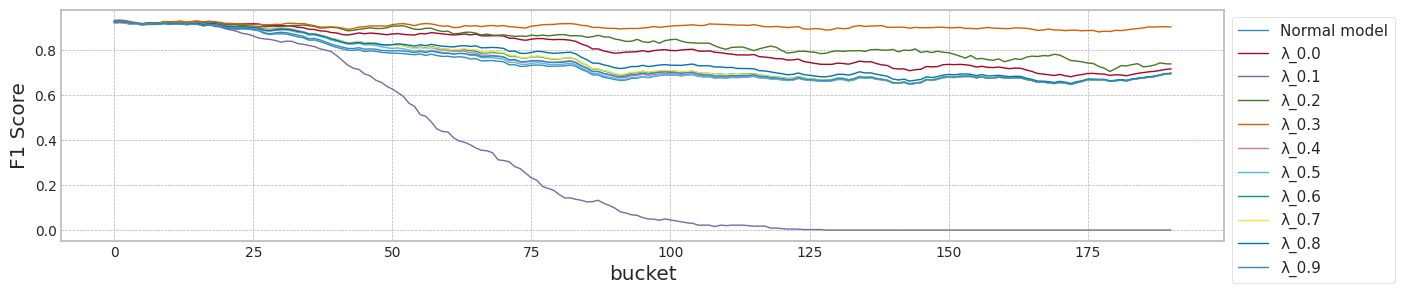

max_mean_lambda= 0.3


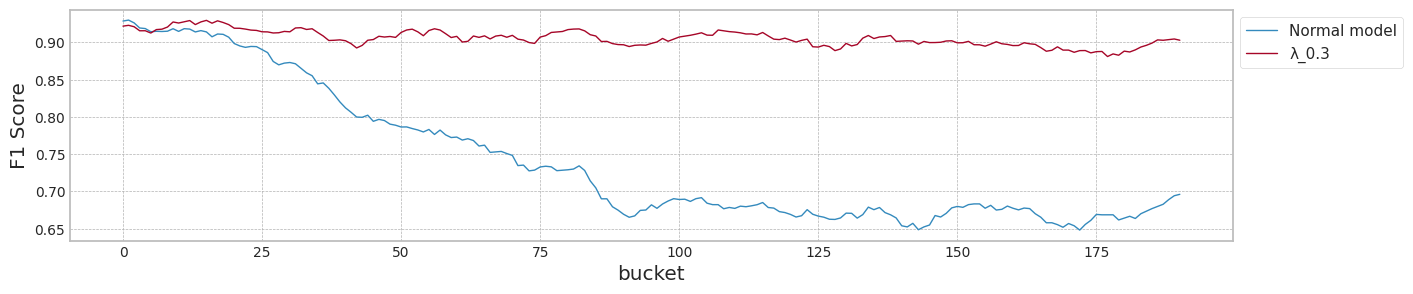

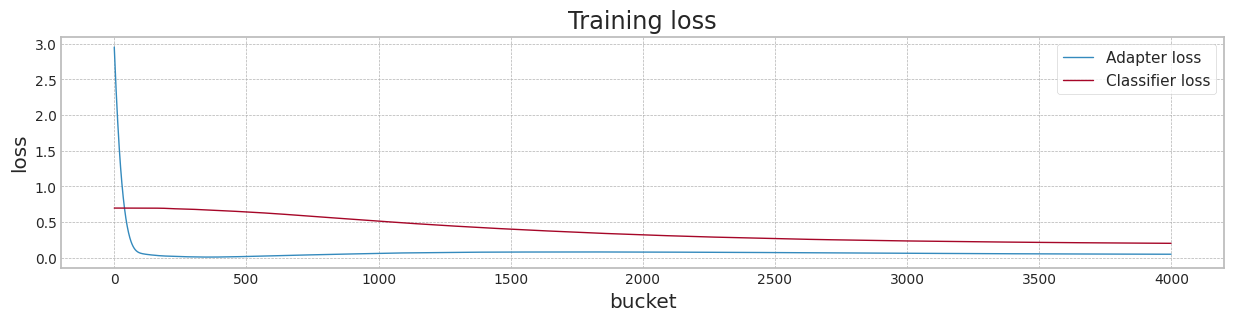

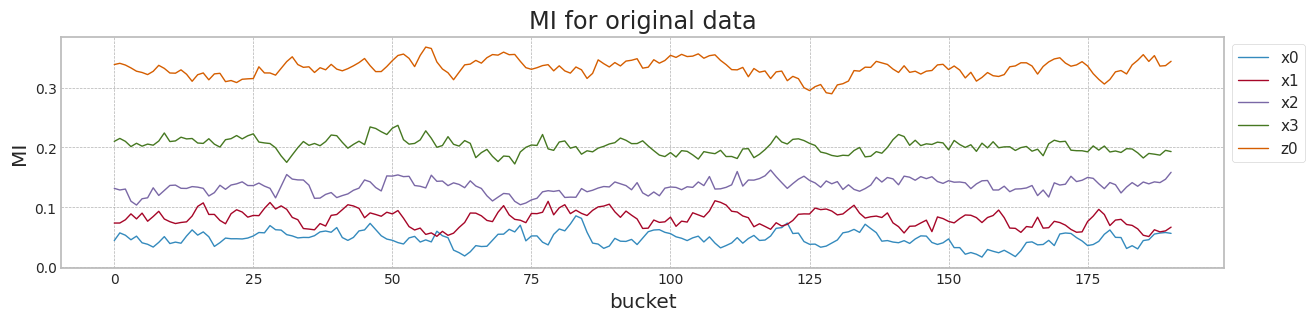

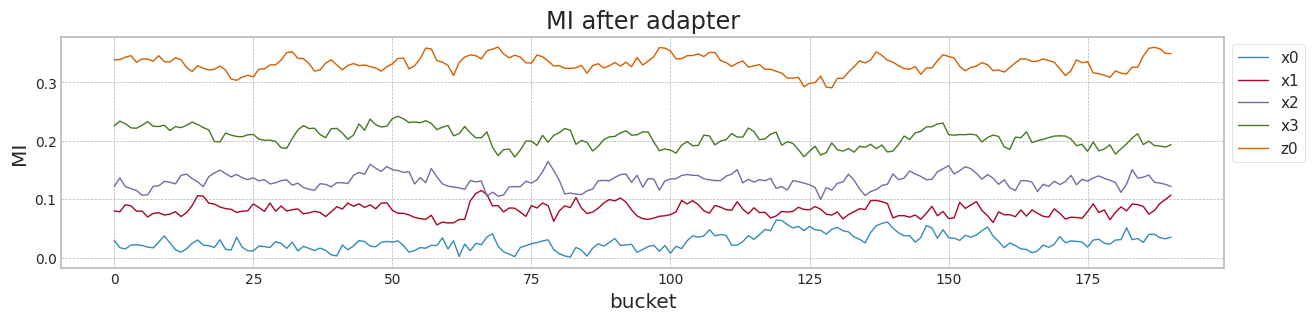

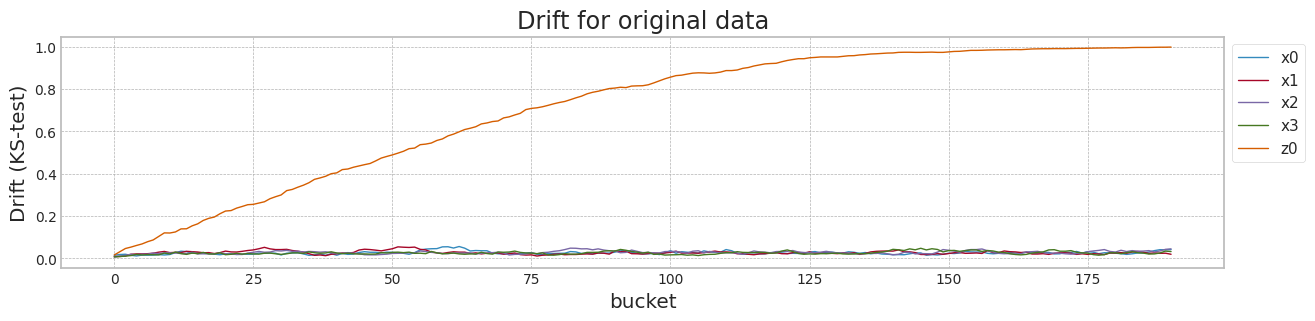

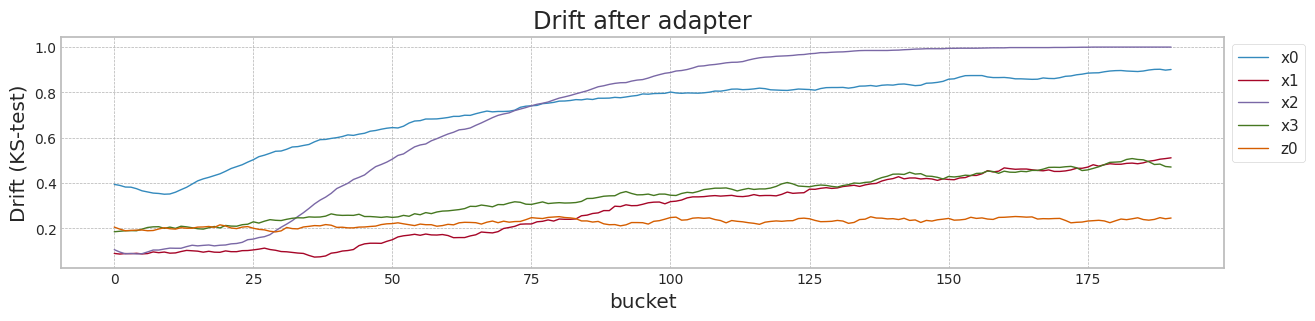

lambda   test_f1   init_f1   mean_f1   last_f1    sum mi  \
0   Case #1, Normal model  0.928571  0.928571  0.740511  0.696125  0.916524   
1                     0.0  0.927869  0.927869  0.807056  0.716629  0.904599   
2                     0.1  0.932092  0.932092  0.294668  0.000000  0.938767   
3                     0.2  0.926856  0.926856  0.838025  0.738421  0.890521   
4                     0.3  0.921739  0.921739  0.905699  0.902852  0.878932   
5                     0.4  0.919565  0.919565  0.750234  0.696125  0.917663   
6                     0.5  0.923411  0.923411  0.745970  0.696125  0.908488   
7                     0.6  0.924579  0.924579  0.754747  0.696125  0.894451   
8                     0.7  0.923660  0.923660  0.754914  0.696125  0.911935   
9                     0.8  0.924824  0.924824  0.766296  0.697388  0.902292   
10                    0.9  0.925906  0.925906  0.746869  0.696125  0.931450   

      std mi  sum * std   sum 1/2   std 1/2   sum 2/2   std 2/2   sum 1-2  \
0   0.126690   0.116114  0.938647  0.124392  0.847101  0.126034  0.091547   
1   0.134011   0.121226  0.946093  0.127140  0.844219  0.127460  0.101874   
2   0.130947   0.122929  0.953509  0.136473  0.887136  0.125314  0.066374   
3   0.133156   0.118578  0.940381  0.135252  0.826709  0.132756  0.113672   
4   0.139781   0.122858  0.902617  0.140724  0.834792  0.137728  0.067826   
5   0.131062   0.120270  0.899525  0.143167  0.857450  0.124276  0.042075   
6   0.139580   0.126807  0.928864  0.140427  0.849352  0.137659  0.079512   
7   0.137284   0.122794  0.940514  0.139623  0.832289  0.139772  0.108225   
8   0.135364   0.123443  0.950216  0.138638  0.841436  0.135491  0.108780   
9   0.133484   0.120442  0.934547  0.139353  0.825928  0.133388  0.108618   
10  0.136715   0.127343  0.951253  0.137121  0.859531  0.135265  0.091722   

     std 1-2   sum 1+2   std 1+2  
0   0.001642  1.785748  0.250427  
1   0.000319  1.790311  0.254600  
2   0.011159  1.840645  0.261787  
3   0.002497  1.767090  0.268008  
4   0.002996  1.737409  0.278452  
5   0.018891  1.756974  0.267443  
6   0.002767  1.778215  0.278086  
7   0.000149  1.772803  0.279395  
8   0.003148  1.791653  0.274129  
9   0.005964  1.760475  0.272741  
10  0.001857  1.810784  0.272386

In [123]:
drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 400)

## synthetic data의 생성 (Case #5 - Case #1,2,3,4의 상황이 각 feature에 혼재되어 있는 경우)

### Dataset 준비

In [148]:
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.5 , 0.7, 2.5])

x4 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x4[:,ix] = np.random.normal(1,cor_,data_size)

y4_array = []
cor_const = cor[4]
cor_const2 = 3/x4.shape[0]
for ii in range(x4.shape[0]):
    # Case #2, MI의 증감(상대적), Drift의 고정 - z0
    cor[4] = cor[4] - cor_const / x4.shape[0]
    e = np.random.normal(0.0, 2.0)
    # Case #3 MI의 증감(상대적), Drift의 증가 - x3
    e1 = np.random.normal(0.0, 3*cor_const2 * ii)
    x4[ii,3] = x4[ii,3] + e1
    y4_array.append(np.sum(cor * x4[ii])+e)

y4 = [1 if y_ > 5 else 0 for y_ in y4_array]

for i in range(len(y4)):
    #Case #1 MI의 감소, Drift의 증가 - x2
    x4[i,2] = y4[i] + np.random.normal(1,0.5+(i/data_size))
    #Case #4 MI의 고정, Drift의 증가 - x1
    x4[i,1] = y4[i] + np.random.normal(0.0 + 4*(i/data_size),cor[1])


### 실험

MI Analysis MI Max 0.14553, Min 0.02498, Mean 0.08409, Std 0.04454
Dataset structure X_train, (1800, 5) X_test, (1800, 5) X_live (39800, 5)
Truncate 7200 rows from live_set (39800, 5)
Search MI & Drift...for X_live_set (191, 1800, 5)


100%|██████████| 191/191 [00:09<00:00, 21.17it/s]


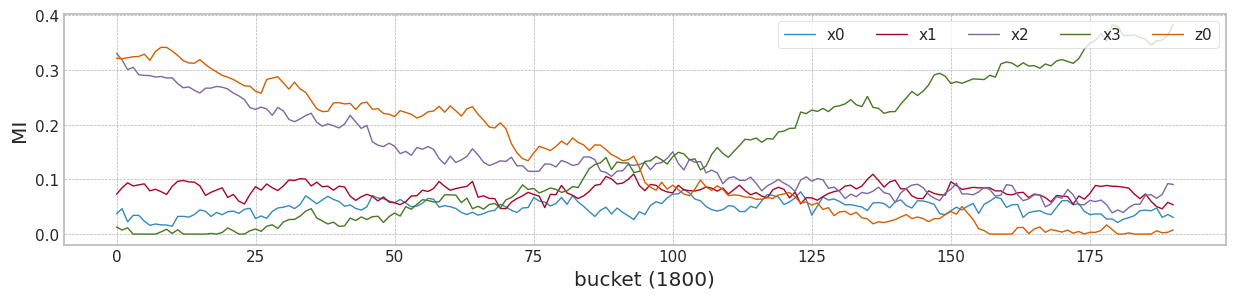

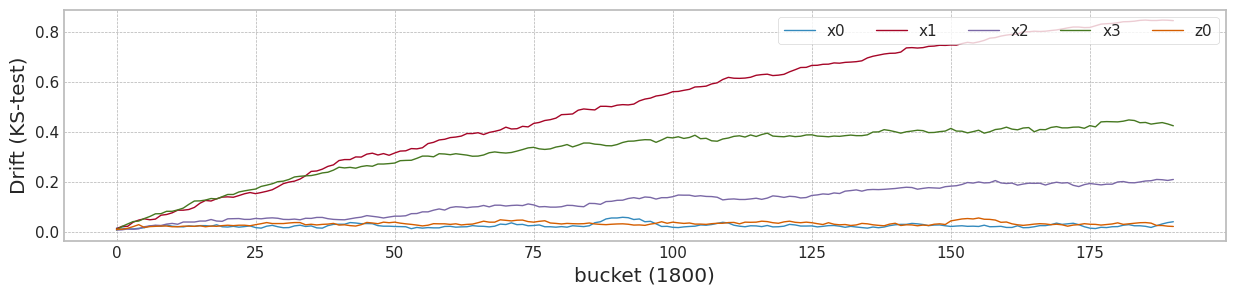

In [150]:
columns=['x0','x1','x2','x3','z0']
X4 = pd.DataFrame(x4,columns=columns)

train_size = 1800
test_size = 200

X1,Y1 = check_mi_drift(X4, y4,train_size, test_size)

In [152]:
X1['b'] = [int(b/100) for b in X1.index.values]
X1

x0        x1        x2        x3        z0    b
0      0.519751  0.387778  0.275001  0.533123  0.339159    0
1      0.605565  0.563470  0.367791  0.564815  0.666164    0
2      0.551222  0.399274  0.575028  0.713089  0.471856    0
3      0.335978  0.536640  0.780598  0.511856  0.609888    0
4      0.496805  0.604664  0.272540  0.446896  0.472373    0
...         ...       ...       ...       ...       ...  ...
39995  0.325122  0.740146  0.182519  0.865448  0.717378  399
39996  0.350268  1.214331  0.189902  0.003441  0.701927  399
39997  0.553850  1.108139  0.668622  2.844378  0.491374  399
39998  0.426469  1.195488  0.410763  1.294958  0.775500  399
39999  0.532744  1.002247  0.002511  3.468541  0.511368  399

[40000 rows x 6 columns]

lambda_f2 1.0
######################### Lambda -0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:05<00:00, 683.62it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9474662947466295
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 21.18it/s]


mean of drift:
x0    0.024977
x1    0.502824
x2    0.120791
x3    0.320617
z0    0.032225
dtype: float64
Mean F1 for all data: 0.7787885224109372
######################### Lambda 0.0 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 233.54it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9589041095890412
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 21.13it/s]


mean of drift:
x0    1.000000
x1    0.832894
x2    0.998941
x3    1.000000
z0    0.856399
dtype: float64
Mean F1 for all data: 0.7314627974716356
######################### Lambda 0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 235.46it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9565627950897073
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 21.08it/s]


mean of drift:
x0    0.743773
x1    0.383738
x2    0.303578
x3    0.532373
z0    0.286841
dtype: float64
Mean F1 for all data: 0.7275853470265128
######################### Lambda 0.2 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 236.15it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9498829039812646
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 21.03it/s]


mean of drift:
x0    0.716603
x1    0.377350
x2    0.471597
x3    0.488307
z0    0.186373
dtype: float64
Mean F1 for all data: 0.7733250794362482
######################### Lambda 0.3 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 236.79it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9476145930776426
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 21.13it/s]


mean of drift:
x0    0.747871
x1    0.158706
x2    0.261216
x3    0.388421
z0    0.223470
dtype: float64
Mean F1 for all data: 0.6708638193033607
######################### Lambda 0.4 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 234.73it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9476635514018691
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 21.22it/s]


mean of drift:
x0    0.415201
x1    0.192720
x2    0.279831
x3    0.352560
z0    0.292824
dtype: float64
Mean F1 for all data: 0.6590349868253497
######################### Lambda 0.5 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 236.68it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9446768944676893
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 21.08it/s]


mean of drift:
x0    0.387609
x1    0.245439
x2    0.257382
x3    0.340134
z0    0.305887
dtype: float64
Mean F1 for all data: 0.6569703110947919
######################### Lambda 0.6 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 237.68it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9437470943747093
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 21.27it/s]


mean of drift:
x0    0.379738
x1    0.287449
x2    0.396227
x3    0.331992
z0    0.340143
dtype: float64
Mean F1 for all data: 0.5715214436798116
######################### Lambda 0.7 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 236.97it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9425393883225208
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 21.36it/s]


mean of drift:
x0    0.363889
x1    0.324424
x2    0.391222
x3    0.325314
z0    0.247941
dtype: float64
Mean F1 for all data: 0.5792736931692742
######################### Lambda 0.8 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 233.55it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9390581717451524
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 20.91it/s]


mean of drift:
x0    0.289599
x1    0.382603
x2    0.359430
x3    0.318810
z0    0.302891
dtype: float64
Mean F1 for all data: 0.575447420494821
######################### Lambda 0.9 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 238.72it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9378739070409572
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:09<00:00, 21.14it/s]


mean of drift:
x0    0.193956
x1    0.428994
x2    0.170134
x3    0.314075
z0    0.218575
dtype: float64
Mean F1 for all data: 0.6477449577796353


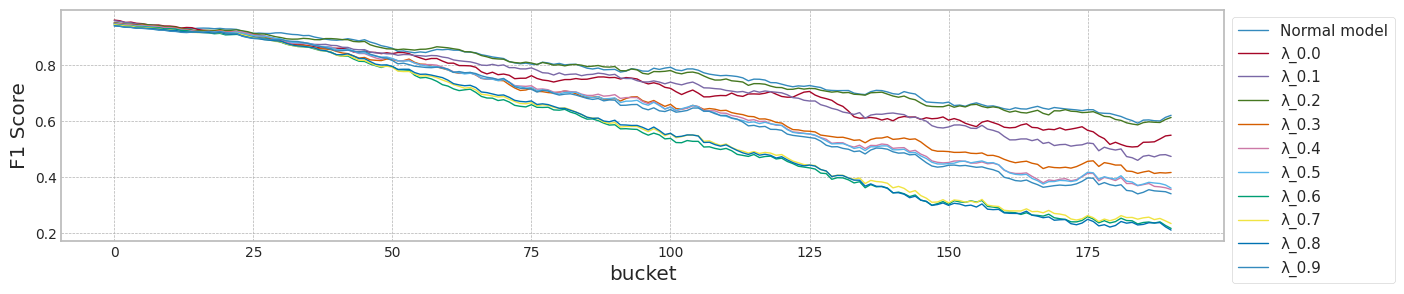

max_mean_lambda= 0.2


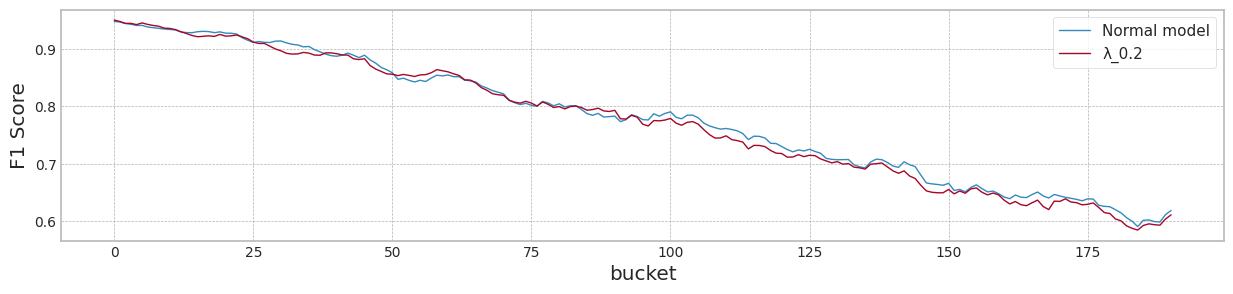

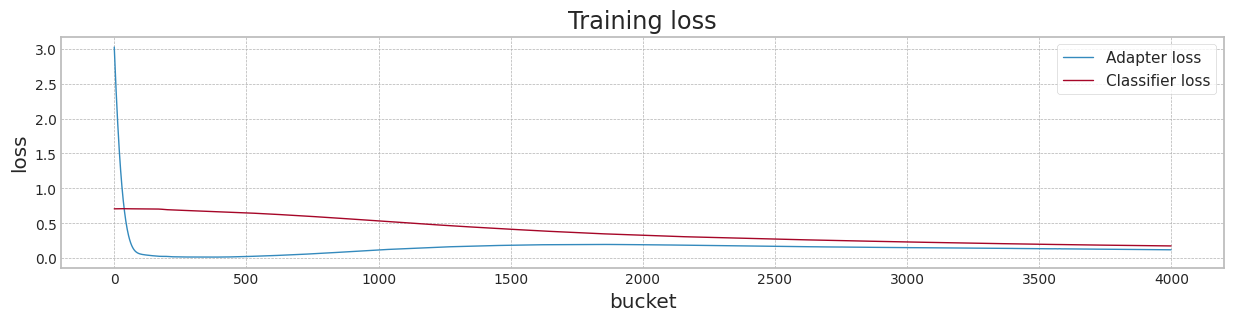

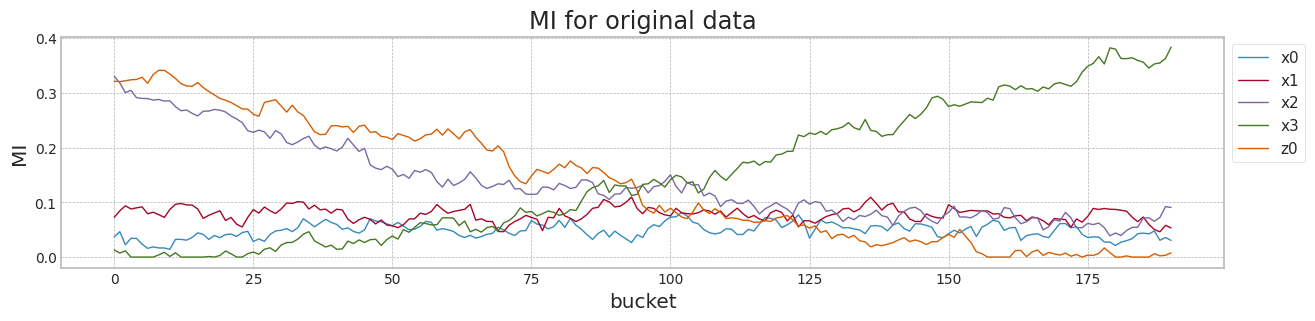

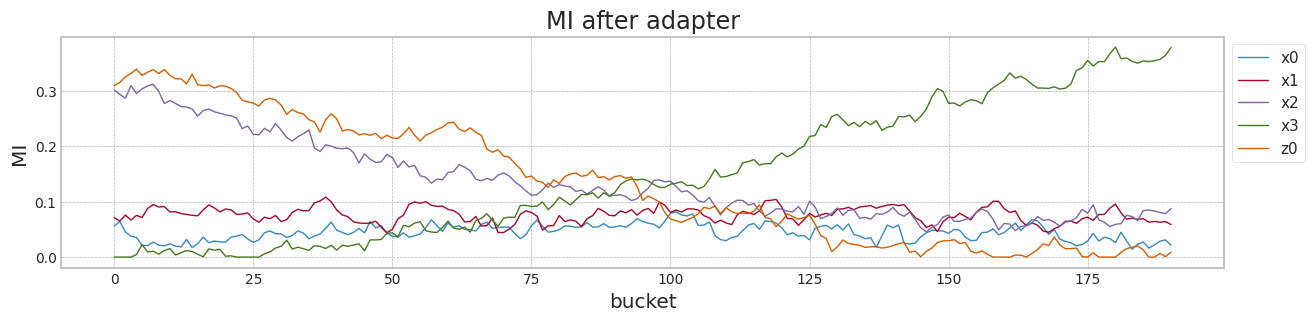

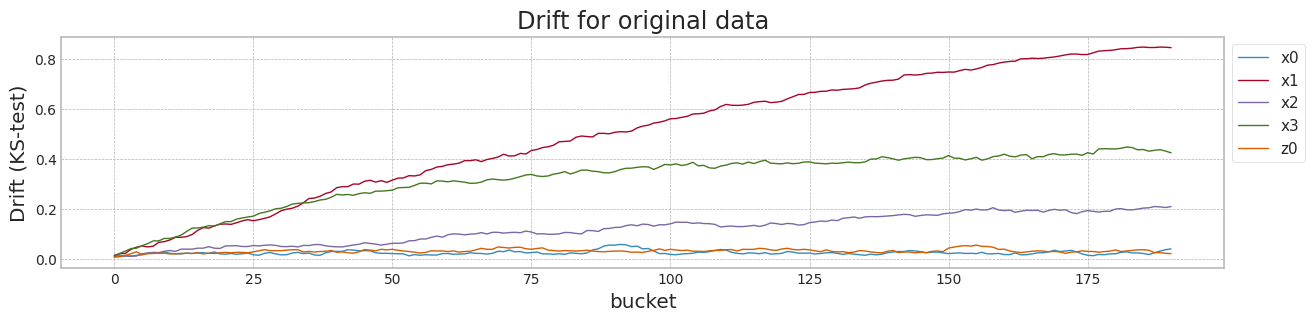

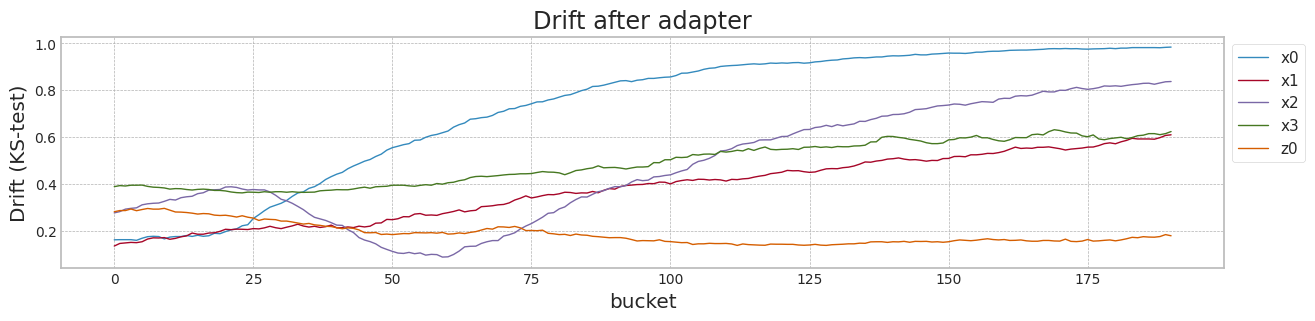

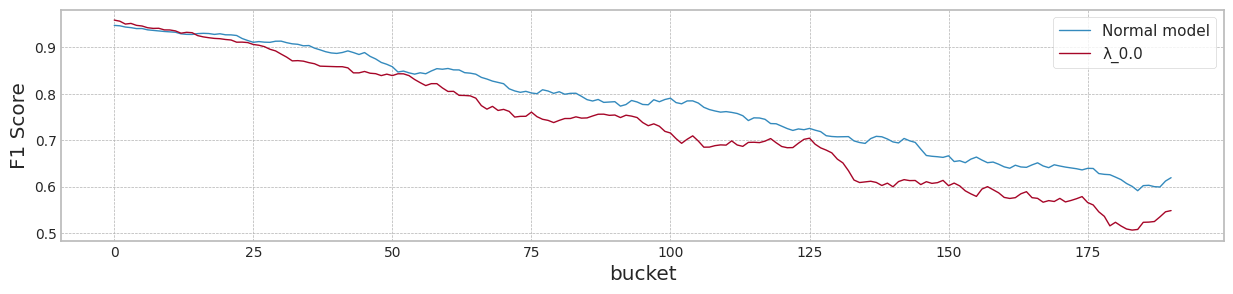

lambda   test_f1   init_f1   mean_f1   last_f1    sum mi  \
0   Case #1, Normal model  0.947466  0.947466  0.778789  0.619145  0.799602   
1                     0.0  0.958904  0.958904  0.731463  0.548214  0.807000   
2                     0.1  0.956563  0.956563  0.727585  0.472387  0.828122   
3                     0.2  0.949883  0.949883  0.773325  0.611540  0.800305   
4                     0.3  0.947615  0.947615  0.670864  0.415172  0.820905   
5                     0.4  0.947664  0.947664  0.659035  0.354559  0.821046   
6                     0.5  0.944677  0.944677  0.656970  0.359504  0.833098   
7                     0.6  0.943747  0.943747  0.571521  0.215580  0.842037   
8                     0.7  0.942539  0.942539  0.579274  0.232959  0.825643   
9                     0.8  0.939058  0.939058  0.575447  0.209692  0.786158   
10                    0.9  0.937874  0.937874  0.647745  0.339196  0.765959   

      std mi  sum * std   sum 1/2   std 1/2   sum 2/2   std 2/2   sum 1-2  \
0   0.160276   0.128157  0.848758  0.171835  0.785478  0.139901  0.063280   
1   0.147478   0.119015  0.825000  0.157654  0.781269  0.144637  0.043731   
2   0.152064   0.125927  0.848436  0.166245  0.813546  0.143789  0.034890   
3   0.156579   0.125311  0.800203  0.165665  0.817902  0.144892  0.017699   
4   0.155509   0.127658  0.800850  0.164503  0.824561  0.143500  0.023711   
5   0.158721   0.130318  0.792873  0.169421  0.822338  0.151225  0.029465   
6   0.157967   0.131602  0.818988  0.169930  0.811872  0.150004  0.007115   
7   0.158100   0.133126  0.819009  0.172994  0.836873  0.147974  0.017864   
8   0.160222   0.132286  0.829010  0.173280  0.805875  0.146827  0.023135   
9   0.163062   0.128193  0.822058  0.174128  0.773215  0.148304  0.048843   
10  0.156110   0.119573  0.815690  0.172299  0.755503  0.144804  0.060187   

     std 1-2   sum 1+2   std 1+2  
0   0.031935  1.634236  0.311736  
1   0.013017  1.606269  0.302291  
2   0.022455  1.661983  0.310034  
3   0.020773  1.618105  0.310556  
4   0.021003  1.625411  0.308003  
5   0.018197  1.615211  0.320646  
6   0.019926  1.630860  0.319935  
7   0.025021  1.655881  0.320968  
8   0.026453  1.634884  0.320108  
9   0.025824  1.595274  0.322432  
10  0.027494  1.571193  0.317103

In [156]:
drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 400)

## real-world data(Loan data)의 실험

### Dataset 준비

#### Data load

In [157]:

if True:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [158]:

df_accepted = pd.read_csv("/content/drive/MyDrive/Drift/accepted_2007_to_2018Q4.csv")

print(df_accepted.shape)

(2260701, 151)


#### Data 정제

In [159]:
# for the sake of simplicity, let's consider only Fully Paid and Charged Off values:
df_accepted = df_accepted[df_accepted.loan_status.isin(['Fully Paid', 'Charged Off'])]
print(df_accepted.shape)

cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(50).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# maybe we can go further, and eliminate columns up to title:
cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(45).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# Remaining columns have missing data points, but they account for less than 0.2% of the total data. Let's remove the rows that are missing those values in those columns with dropna():
df_accepted = df_accepted.dropna()
print(df_accepted.shape)

# These are constant columns. We can drop it either.
cols_to_drop = ['out_prncp', 'out_prncp_inv', 'policy_code']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# It seems we have many "duplicated" information. Let's drop some columns, based on visual inspection at corr_pairs dataframe:
cols_to_drop = ['fico_range_low', 'funded_amnt_inv', 'funded_amnt', 'total_pymnt_inv', 'total_pymnt', 'installment', 'collection_recovery_fee', 'total_rec_prncp', 'last_fico_range_low']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

values = df_accepted.loan_status.unique()
encode = [1,0]
d = dict(zip(values, encode))
df_accepted['loan_paid'] = df_accepted['loan_status'].map(d)
df_accepted = df_accepted.drop(columns=['loan_status'])

df_accepted

(1345310, 151)
(1345310, 101)
(1345310, 56)
(1341026, 56)
(1341026, 53)
(1341026, 44)


id  loan_amnt        term  int_rate grade sub_grade  \
0        68407277     3600.0   36 months     13.99     C        C4   
1        68355089    24700.0   36 months     11.99     C        C1   
2        68341763    20000.0   60 months     10.78     B        B4   
4        68476807    10400.0   60 months     22.45     F        F1   
5        68426831    11950.0   36 months     13.44     C        C3   
...           ...        ...         ...       ...   ...       ...   
2260688  89905081    18000.0   60 months      9.49     B        B2   
2260690  88948836    29400.0   60 months     13.99     C        C3   
2260691  89996426    32000.0   60 months     14.49     C        C4   
2260692  90006534    16000.0   60 months     12.79     C        C1   
2260697  88224441    24000.0   60 months     14.49     C        C4   

        home_ownership  annual_inc verification_status   issue_d  ...  \
0             MORTGAGE     55000.0        Not Verified  Dec-2015  ...   
1             MORTGAGE     65000.0        Not Verified  Dec-2015  ...   
2             MORTGAGE     63000.0        Not Verified  Dec-2015  ...   
4             MORTGAGE    104433.0     Source Verified  Dec-2015  ...   
5                 RENT     34000.0     Source Verified  Dec-2015  ...   
...                ...         ...                 ...       ...  ...   
2260688            OWN    130000.0        Not Verified  Oct-2016  ...   
2260690       MORTGAGE    180792.0        Not Verified  Oct-2016  ...   
2260691       MORTGAGE    157000.0     Source Verified  Oct-2016  ...   
2260692           RENT    150000.0        Not Verified  Oct-2016  ...   
2260697           RENT    110000.0        Not Verified  Oct-2016  ...   

        application_type acc_now_delinq chargeoff_within_12_mths delinq_amnt  \
0             Individual            0.0                      0.0         0.0   
1             Individual            0.0                      0.0         0.0   
2              Joint App            0.0                      0.0         0.0   
4             Individual            0.0                      0.0         0.0   
5             Individual            0.0                      0.0         0.0   
...                  ...            ...                      ...         ...   
2260688       Individual            0.0                      0.0         0.0   
2260690       Individual            0.0                      0.0         0.0   
2260691       Individual            0.0                      0.0         0.0   
2260692       Individual            0.0                      0.0         0.0   
2260697       Individual            0.0                      0.0         0.0   

        pub_rec_bankruptcies  tax_liens  hardship_flag disbursement_method  \
0                        0.0        0.0              N                Cash   
1                        0.0        0.0              N                Cash   
2                        0.0        0.0              N                Cash   
4                        0.0        0.0              N                Cash   
5                        0.0        0.0              N                Cash   
...                      ...        ...            ...                 ...   
2260688                  0.0        0.0              N                Cash   
2260690                  0.0        0.0              N                Cash   
2260691                  0.0        0.0              N                Cash   
2260692                  3.0        0.0              N                Cash   
2260697                  1.0        0.0              N                Cash   

         debt_settlement_flag  loan_paid  
0                           N          1  
1                           N          1  
2                           N          1  
4                           N          1  
5                           N          1  
...                       ...        ...  
2260688                     N          1  
2260690                     N          1  
2260691     

In [160]:
# droping constant columns
print(df_accepted.pymnt_plan.value_counts())
print(df_accepted.hardship_flag.value_counts())
cols_to_drop = ['id', 'pymnt_plan', 'hardship_flag']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

print(df_accepted.term.value_counts())

# convert term into either a 36 or 60 integer numeric data type

l1 = df_accepted.term.unique()
l2 = [36, 60]
d = dict(zip(l1, l2))

df_accepted['term'] = df_accepted['term'].map(d)

# as grade is part of sub_grade, so let's just drop the grade feature.

df_accepted = df_accepted.drop(columns='grade')

df_accepted = pd.get_dummies(df_accepted, columns = ['sub_grade'], prefix='', prefix_sep='', drop_first=True)

cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

# for these columns, let's just create dummy variables, concatenate them with the original dataframe and drop original columns.

df_accepted = pd.get_dummies(df_accepted, columns = ['verification_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['application_type'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['initial_list_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['purpose'], prefix='', prefix_sep='', drop_first=True)
print(df_accepted.shape)

df_accepted['home_ownership'] = df_accepted.home_ownership.replace('NONE', 'ANY')
df_accepted = pd.get_dummies(df_accepted, columns = ['home_ownership'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=[ 'url', 'last_pymnt_d', 'last_credit_pull_d'])
df_accepted = df_accepted.drop(columns=['zip_code', 'addr_state'])
df_accepted = pd.get_dummies(df_accepted, columns = ['disbursement_method'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['debt_settlement_flag'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=['earliest_cr_line'])
print(df_accepted.shape)


df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jan','01')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Feb','02')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Mar','03')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Apr','04')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('May','05')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jun','06')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jul','07')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Aug','08')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Sep','09')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Oct','10')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Dec','11')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Nov','12')

def reorder_issue_d(dt):
    a = dt.split('-')
    return a[1]+a[0]

reorder_issue_d('01-2009')

df_accepted['issue_d'] = df_accepted['issue_d'].apply(reorder_issue_d)
df_accepted = df_accepted.sort_values(by='issue_d')
df_accepted.reset_index(drop=True, inplace=True)

df_accepted.info()

n    1341026
Name: pymnt_plan, dtype: int64
N    1341026
Name: hardship_flag, dtype: int64
(1341026, 41)
Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'url', 'purpose', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')
 36 months    1017398
 60 months     323628
Name: term, dtype: int64
Index(['home_ownership', 'verification_status', 'issue_d', 'url', 'purpose',
       'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status',
       'last_pymnt_d', 'last_credit_pull_d', 'application_type',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')
(1341026, 86)
(1341026, 83)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341026 entries, 0 to 1341025
Data columns (total 83 columns):
 #   Column                      Non-Null Count    Dtype  

#### Dataset 만들기

In [174]:
X = {}
Y = {}

df = df_accepted[df_accepted['issue_d'].str.startswith('2007') + df_accepted['issue_d'].str.startswith('2008') + df_accepted['issue_d'].str.startswith('2009')].copy()
df = df.drop(columns=['issue_d'])


X[2009] = df.loc[:, df.columns != 'loan_paid'].values
Y[2009] = df.loan_paid.values


for year in range(2010,2019):
    print(year)
    df = df_accepted[df_accepted['issue_d'].str.startswith(str(year))].copy()
    df = df.drop(columns=['issue_d'])
    X[year] = df.loc[:, df.columns != 'loan_paid'].values
    Y[year] = df.loan_paid.values

2010
2011
2012
2013
2014
2015
2016
2017
2018


In [175]:

X[2010].shape

(11497, 81)

In [176]:
COLUMNS = df.loc[:, df.columns != 'loan_paid'].columns
COLUMNS

Index(['loan_amnt', 'term', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs',
       'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'last_pymnt_amnt', 'last_fico_range_high',
       'collections_12_mths_ex_med', 'acc_now_delinq',
       'chargeoff_within_12_mths', 'delinq_amnt', 'pub_rec_bankruptcies',
       'tax_liens', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1',
       'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3',
       'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5',
       'Source Verified', 'Verified', 'Joint App', 'w', 'credit_card',
       'debt_consolidation', 'educational', 'home_improvement', 'house',
       'major_purchase', 'medical', 'moving', 'other', 'renewable_energy',
       'small_business', 'vacation', 'wedding', 'MORTGAGE', 'OTHER', 'OWN',
       'RENT', 'DirectPay', 'Y'],
      dtype

In [177]:
X_df = pd.DataFrame(X[2010],columns=COLUMNS)
mi_scores = make_mi_scores(X_df, Y[2010], discrete_features="auto")
print(mi_scores)

recoveries              0.375499
last_fico_range_high    0.094427
last_pymnt_amnt         0.085847
total_rec_late_fee      0.036900
int_rate                0.023340
                          ...   
pub_rec_bankruptcies    0.000000
E4                      0.000000
A4                      0.000000
E2                      0.000000
G3                      0.000000
Name: MI Scores, Length: 81, dtype: float64


In [178]:
# MI Top 5, columns
top_columns = list(mi_scores[0:5].index)
top_columns

['recoveries',
 'last_fico_range_high',
 'last_pymnt_amnt',
 'total_rec_late_fee',
 'int_rate']

+ 일부러 예측 확률을 떨어뜨리기 위해 (조정), "recoveries" feature를 제외 한다.

In [179]:
top_columns = list(mi_scores[1:10].index)
top_columns

['last_fico_range_high',
 'last_pymnt_amnt',
 'total_rec_late_fee',
 'int_rate',
 'term',
 'fico_range_high',
 'medical',
 'small_business',
 'F5']

In [180]:
top_columns_index = [list(COLUMNS).index(tc) for tc in top_columns]
top_columns_index

[17, 16, 14, 2, 1, 6, 68, 72, 52]

In [181]:
# 2010년의 data를 기준으로 그 이후의 data 들...
X2 = np.concatenate((X[2010],X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2010],Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))
X2 = pd.DataFrame(X2,columns = COLUMNS)[top_columns]
#X2_df_t5 = X2_df[top_columns]

### 실험

MI Analysis MI Max 0.31533, Min 0.00001, Mean 0.08703, Std 0.11466
Dataset structure X_train, (10000, 9) X_test, (10000, 9) X_live (1278183, 9)
Truncate 28665 rows from live_set (1278183, 9)
Search MI & Drift...for X_live_set (848, 10000, 9)


100%|██████████| 848/848 [05:20<00:00,  2.64it/s]


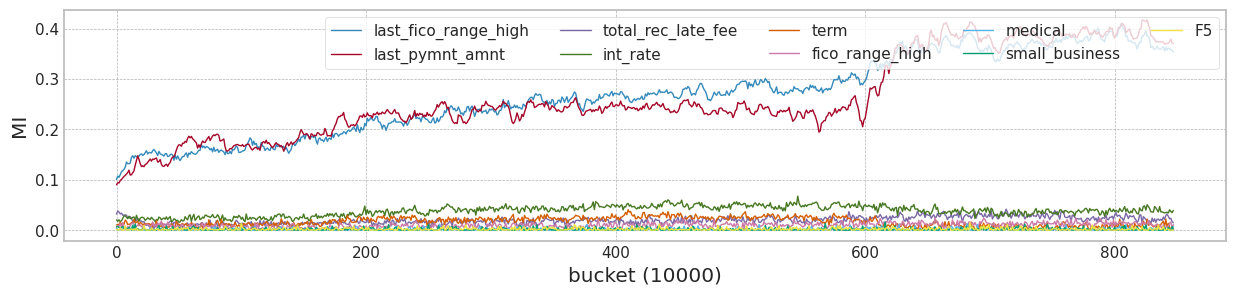

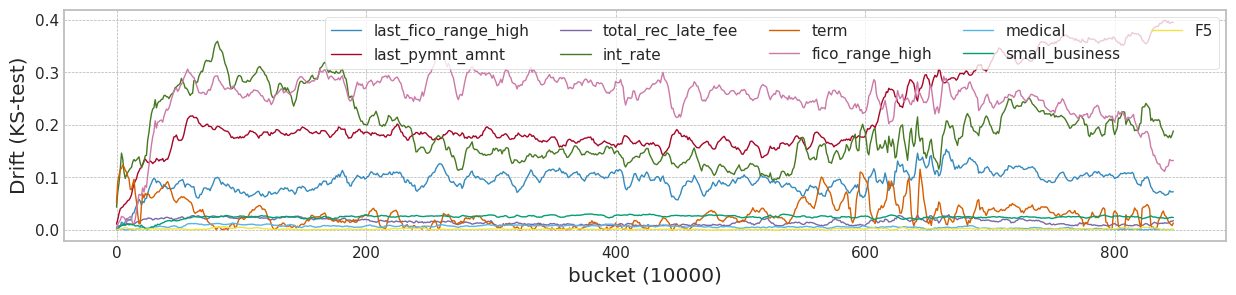

In [182]:
train_size = 10000
test_size = 1497

X1,Y1 = check_mi_drift(X2, Y2, train_size, test_size)

In [183]:
X1['b'] = [int(b/1000) for b in X1.index.values]
X1

last_fico_range_high  last_pymnt_amnt  total_rec_late_fee  int_rate  \
0                    0.928910         0.032896            0.000000  0.502466   
1                    0.863744         0.010440            0.000000  0.416769   
2                    0.727488         0.381296            0.000000  0.566584   
3                    0.869668         0.021731            0.000000  0.652281   
4                    0.952607         0.027513            0.000000  0.395191   
...                       ...              ...                 ...       ...   
1279675              0.917062         0.000269            0.090128  0.278052   
1279676              0.857820         0.403841            0.000000  0.278052   
1279677              0.905213         0.334665            0.000000  0.157213   
1279678              0.922986         0.971979            0.000000 -0.006165   
1279679              0.881517         0.377212            0.000000  1.564118   

         term  fico_range_high  medical  small_business   F5     b  
0         0.0          0.12500      0.0             0.0  0.0     0  
1         0.0          0.62500      0.0             0.0  0.0     0  
2         0.0          0.31250      0.0             0.0  0.0     0  
3         0.0          0.00000      0.0             0.0  0.0     0  
4         0.0          0.59375      0.0             0.0  0.0     0  
...       ...              ...      ...             ...  ...   ...  
1279675   0.0          0.25000      1.0             0.0  0.0  1279  
1279676   0.0          0.46875      0.0             0.0  0.0  1279  
1279677   0.0          0.28125      0.0             0.0  0.0  1279  
1279678   0.0          0.71875      0.0             0.0  0.0  1279  
1279679   1.0          0.34375      0.0             0.0  0.0  1279  

[1279680 rows x 10 columns]

lambda_f2 1.0
######################### Lambda -0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:05<00:00, 668.70it/s]


ty torch.Size([10000])
y_hat (10000, 1)
Test f1 score: 0.9303594351732991
X_live.shape (1278183, 10)
Truncate 28665 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [03:06<00:00,  4.54it/s]


mean of drift:
last_fico_range_high    0.117682
last_pymnt_amnt         0.214501
total_rec_late_fee      0.019389
int_rate                0.187503
term                    0.028391
dtype: float64
Mean F1 for all data: 0.8881214917723008
######################### Lambda 0.0 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 227.30it/s]


ty torch.Size([10000])
y_hat (10000, 1)
Test f1 score: 0.9437507031162111
X_live.shape (1278183, 10)
Truncate 28665 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [03:05<00:00,  4.56it/s]


mean of drift:
last_fico_range_high    0.999881
last_pymnt_amnt         1.000000
total_rec_late_fee      1.000000
int_rate                1.000000
term                    1.000000
dtype: float64
Mean F1 for all data: 0.9341246358571359
######################### Lambda 0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 234.83it/s]


ty torch.Size([10000])
y_hat (10000, 1)
Test f1 score: 0.9398471615720523
X_live.shape (1278183, 10)
Truncate 28665 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [03:06<00:00,  4.55it/s]


mean of drift:
last_fico_range_high    0.302111
last_pymnt_amnt         0.460200
total_rec_late_fee      0.677435
int_rate                0.199457
term                    0.745600
dtype: float64
Mean F1 for all data: 0.9048082250682402
######################### Lambda 0.2 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 232.73it/s]


ty torch.Size([10000])
y_hat (10000, 1)
Test f1 score: 0.9384824585259722
X_live.shape (1278183, 10)
Truncate 28665 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [03:07<00:00,  4.52it/s]


mean of drift:
last_fico_range_high    0.255803
last_pymnt_amnt         0.439374
total_rec_late_fee      0.829549
int_rate                0.192733
term                    0.745600
dtype: float64
Mean F1 for all data: 0.9005867599975083
######################### Lambda 0.3 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 230.27it/s]


ty torch.Size([10000])
y_hat (10000, 1)
Test f1 score: 0.9333333333333332
X_live.shape (1278183, 10)
Truncate 28665 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [03:06<00:00,  4.54it/s]


mean of drift:
last_fico_range_high    0.227410
last_pymnt_amnt         0.417154
total_rec_late_fee      0.846344
int_rate                0.192795
term                    0.745600
dtype: float64
Mean F1 for all data: 0.8921365503382814
######################### Lambda 0.4 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 229.98it/s]


ty torch.Size([10000])
y_hat (10000, 1)
Test f1 score: 0.9359696641386783
X_live.shape (1278183, 10)
Truncate 28665 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [03:06<00:00,  4.54it/s]


mean of drift:
last_fico_range_high    0.206685
last_pymnt_amnt         0.399541
total_rec_late_fee      0.808167
int_rate                0.190595
term                    0.745600
dtype: float64
Mean F1 for all data: 0.900136664522174
######################### Lambda 0.5 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 233.91it/s]


ty torch.Size([10000])
y_hat (10000, 1)
Test f1 score: 0.9382407306730455
X_live.shape (1278183, 10)
Truncate 28665 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [03:05<00:00,  4.56it/s]


mean of drift:
last_fico_range_high    0.179392
last_pymnt_amnt         0.380823
total_rec_late_fee      0.752524
int_rate                0.188486
term                    0.745600
dtype: float64
Mean F1 for all data: 0.9063649845006093
######################### Lambda 0.6 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 230.05it/s]


ty torch.Size([10000])
y_hat (10000, 1)
Test f1 score: 0.9307354672947222
X_live.shape (1278183, 10)
Truncate 28665 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [03:07<00:00,  4.53it/s]


mean of drift:
last_fico_range_high    0.156654
last_pymnt_amnt         0.353409
total_rec_late_fee      0.752525
int_rate                0.188850
term                    0.745600
dtype: float64
Mean F1 for all data: 0.8893858771568942
######################### Lambda 0.7 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 232.56it/s]


ty torch.Size([10000])
y_hat (10000, 1)
Test f1 score: 0.9306432623354383
X_live.shape (1278183, 10)
Truncate 28665 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [03:07<00:00,  4.52it/s]


mean of drift:
last_fico_range_high    0.133425
last_pymnt_amnt         0.323810
total_rec_late_fee      0.752524
int_rate                0.188817
term                    0.745600
dtype: float64
Mean F1 for all data: 0.8886895290863144
######################### Lambda 0.8 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 230.71it/s]


ty torch.Size([10000])
y_hat (10000, 1)
Test f1 score: 0.9304515300663386
X_live.shape (1278183, 10)
Truncate 28665 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [03:06<00:00,  4.54it/s]


mean of drift:
last_fico_range_high    0.114183
last_pymnt_amnt         0.279226
total_rec_late_fee      0.677435
int_rate                0.188320
term                    0.745600
dtype: float64
Mean F1 for all data: 0.8883507627046536
######################### Lambda 0.9 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 229.06it/s]


ty torch.Size([10000])
y_hat (10000, 1)
Test f1 score: 0.9303594351732991
X_live.shape (1278183, 10)
Truncate 28665 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [03:06<00:00,  4.55it/s]


mean of drift:
last_fico_range_high    0.095539
last_pymnt_amnt         0.225481
total_rec_late_fee      0.633118
int_rate                0.187925
term                    0.745600
dtype: float64
Mean F1 for all data: 0.8881844286828809


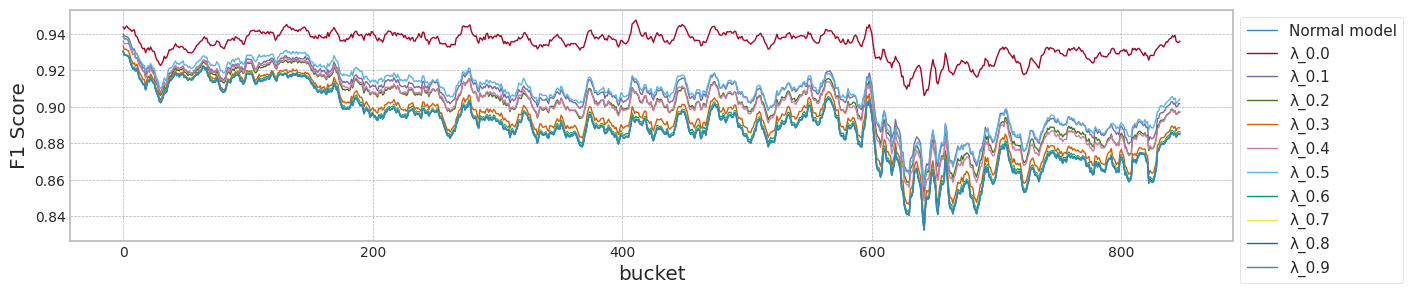

max_mean_lambda= 0.0


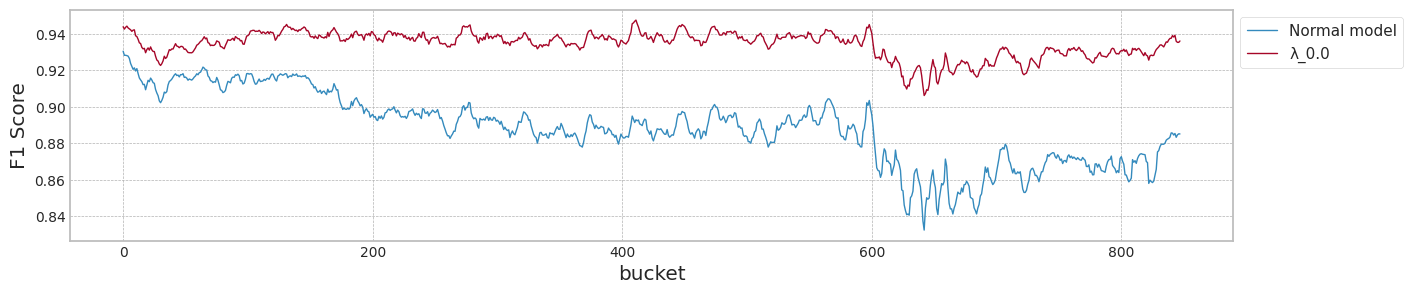

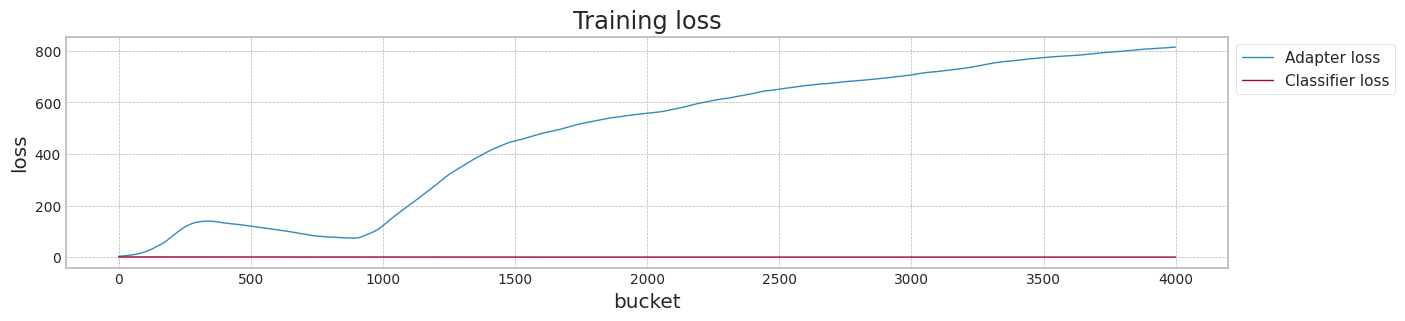

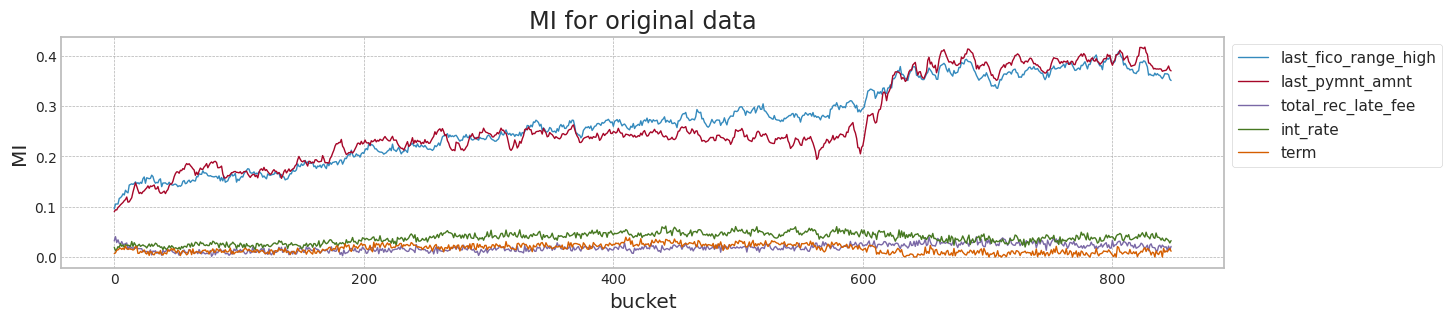

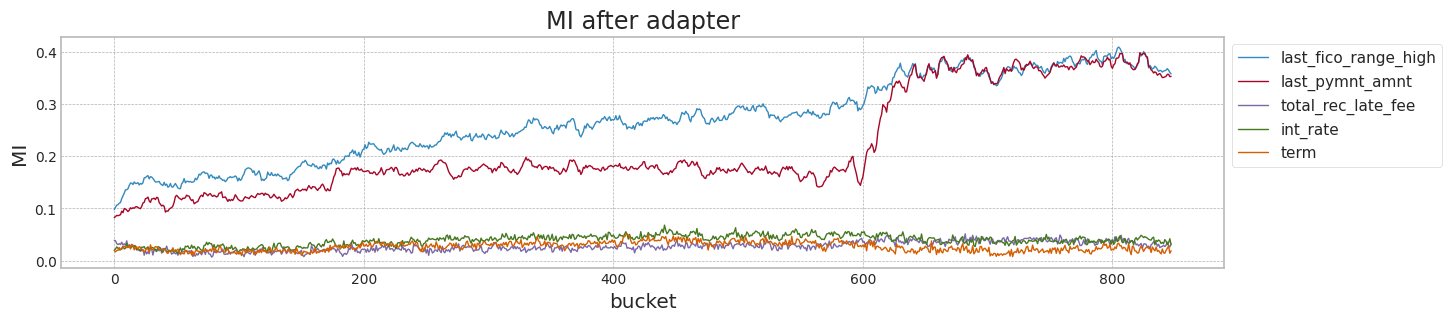

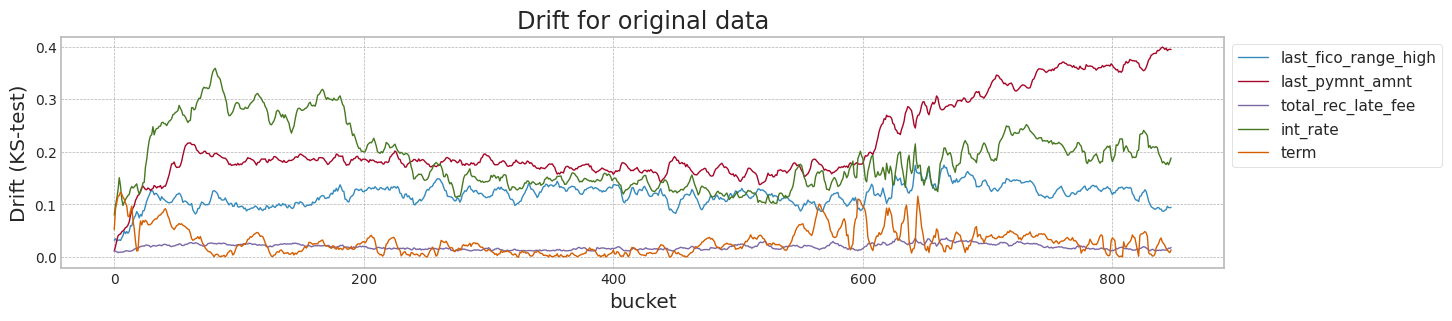

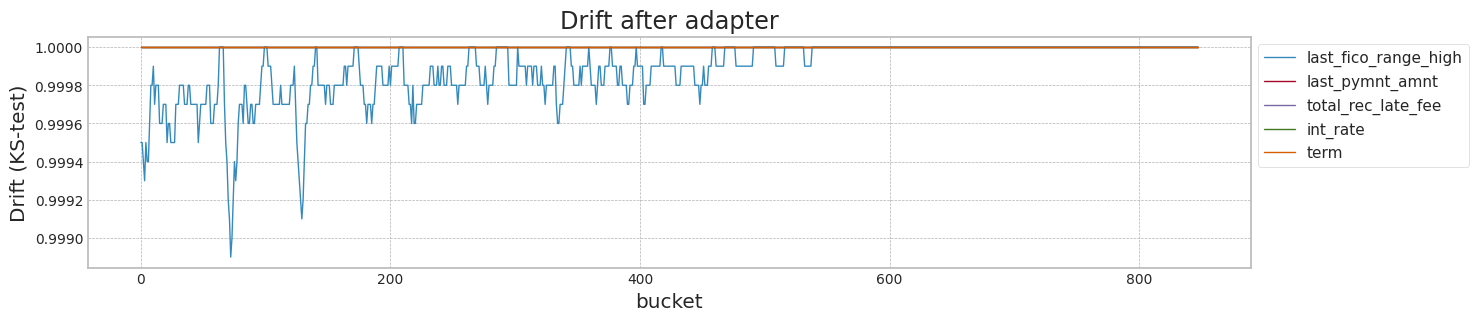

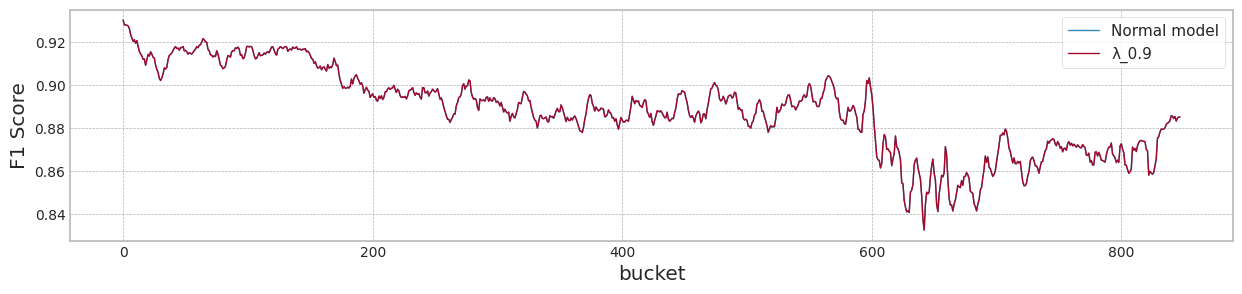

lambda   test_f1   init_f1   mean_f1   last_f1    sum mi  \
0   Case #1, Normal model  0.930359  0.930359  0.888121  0.885070  0.004055   
1                     0.0  0.943751  0.943751  0.934125  0.935954  0.343582   
2                     0.1  0.939847  0.939847  0.904808  0.901564  0.184112   
3                     0.2  0.938482  0.938482  0.900587  0.896922  0.161471   
4                     0.3  0.933333  0.933333  0.892137  0.888366  0.073550   
5                     0.4  0.935970  0.935970  0.900137  0.897289  0.140976   
6                     0.5  0.938241  0.938241  0.906365  0.904308  0.167595   
7                     0.6  0.930735  0.930735  0.889386  0.886158  0.013870   
8                     0.7  0.930643  0.930643  0.888690  0.885416  0.011009   
9                     0.8  0.930452  0.930452  0.888351  0.885120  0.005617   
10                    0.9  0.930359  0.930359  0.888184  0.885120  0.002687   

      std mi  sum * std   sum 1/2   std 1/2       sum 2/2   std 2/2   sum 1-2  \
0   0.000734   0.000003  0.006931  0.001435  6.000000e-04  0.000160  0.006331   
1   0.039911   0.013713  0.319847  0.035840  3.544762e-01  0.045897  0.034629   
2   0.016695   0.003074  0.172742  0.015768  1.963608e-01  0.018323  0.023619   
3   0.014012   0.002263  0.158738  0.014457  1.680324e-01  0.015348  0.009294   
4   0.006702   0.000493  0.074812  0.006179  7.998252e-02  0.007482  0.005171   
5   0.010757   0.001516  0.128502  0.010732  1.456445e-01  0.012549  0.017142   
6   0.011621   0.001948  0.145259  0.010854  1.843723e-01  0.013557  0.039113   
7   0.002223   0.000031  0.020109  0.003311  6.470951e-03  0.001350  0.013638   
8   0.002027   0.000022  0.015672  0.003116  5.080278e-03  0.000743  0.010592   
9   0.001343   0.000008  0.007505  0.001574  6.106227e-15  0.000000  0.007505   
10  0.000536   0.000001  0.004612  0.001002  0.000000e+00  0.000000  0.004612   

     std 1-2   sum 1+2   std 1+2  
0   0.001275  0.007531  0.001595  
1   0.010057  0.674324  0.081736  
2   0.002554  0.369102  0.034091  
3   0.000891  0.326771  0.029806  
4   0.001302  0.154794  0.013661  
5   0.001817  0.274147  0.023281  
6   0.002703  0.329632  0.024412  
7   0.001961  0.026580  0.004660  
8   0.002372  0.020753  0.003859  
9   0.001574  0.007505  0.001574  
10  0.001002  0.004612  0.001002

In [184]:
drift_tolerant(X1, Y1,train_size, test_size,avaible_range = np.max(X1['b']))